In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from scipy import stats

***1. Chargement des données***

In [48]:
df = pd.read_csv('Telco-Churn.csv')

**------------ -------------**

***2. Analyse Exploratoire des données (EDA)***

**2.1. Overview**

In [49]:
print(df.info()) #Types des données et compter les valeurs non-nulles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [50]:
print(df.describe()) #Afficher les tendances centrales de colomnes numériques

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


**2.2. Distirbution des Classes**

In [51]:
print("---- CHURN DISTRIBUTION ------")
print(df['Churn'].value_counts(normalize=True) * 100)

---- CHURN DISTRIBUTION ------
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


*2.2.1. Diagramme Circulaire de la distribution des classes*

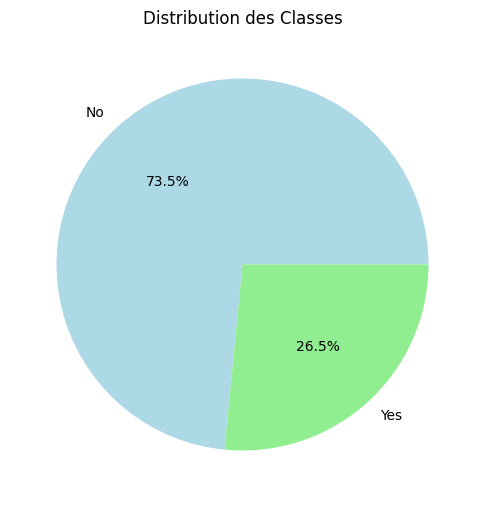

In [52]:
plt.figure(figsize=(6,7))
df['Churn'].value_counts().plot.pie(labels=['No' ,'Yes'],colors=['lightblue' ,'lightgreen'] ,autopct='%1.1f%%')
plt.title('Distribution des Classes')
plt.ylabel('')
plt.show()

**2.3. Visualisation des variables**

*2.3.1. Variables numériques*

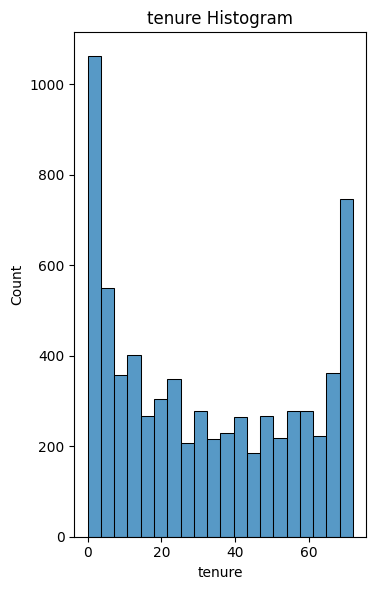

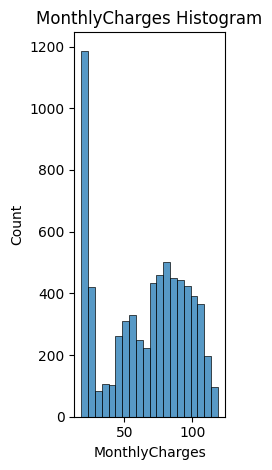

In [53]:
num_vars = ['tenure' ,'MonthlyCharges']
plt.figure(figsize=(10 ,6))
for i ,col in enumerate(num_vars ,1):
    plt.subplot(1 ,3 ,i)
    sns.histplot(df[col] ,bins=20)
    plt.title(f'{col} Histogram')
    plt.tight_layout()
    plt.show()

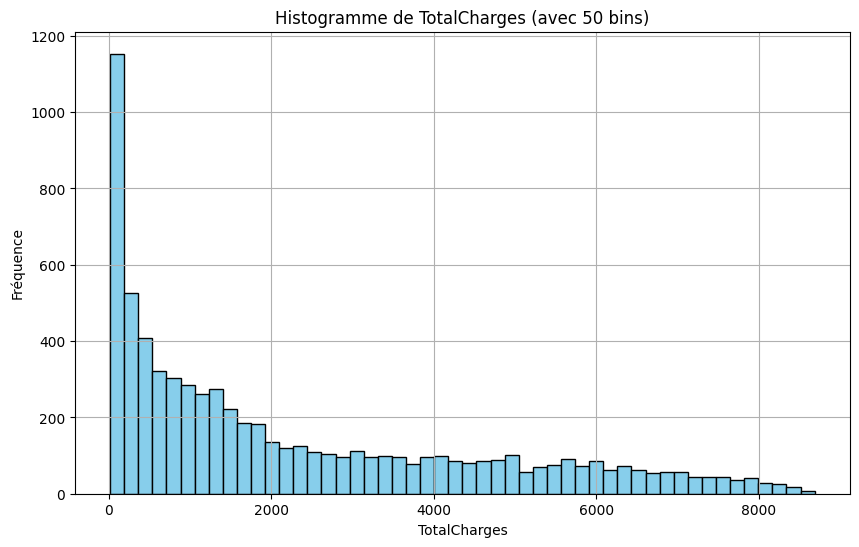

In [54]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 
df = df.dropna(subset=['TotalCharges']) 

plt.figure(figsize=(10, 6))
plt.hist(df['TotalCharges'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogramme de TotalCharges (avec 50 bins)')
plt.xlabel('TotalCharges')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

*2.3.2. Variables categorielles*

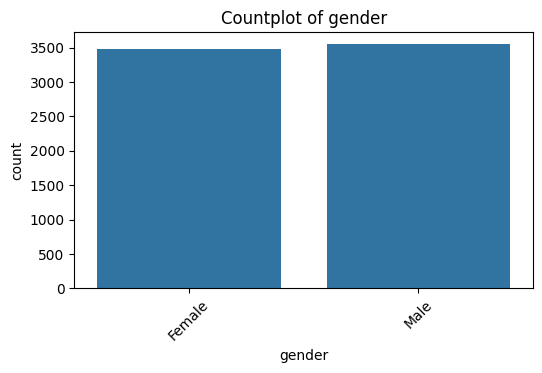

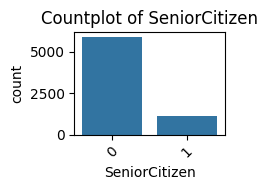

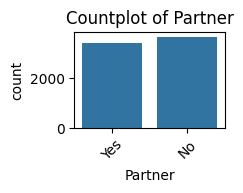

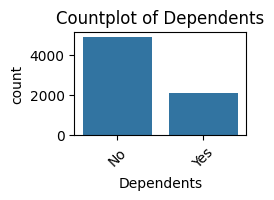

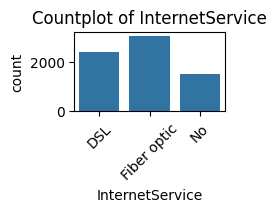

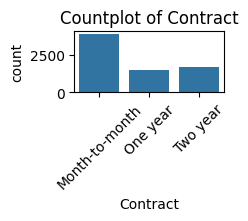

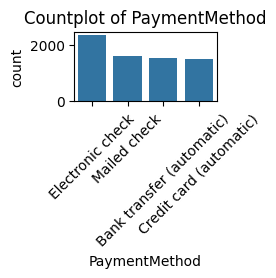

In [55]:
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'Contract', 'PaymentMethod']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3 ,3 ,i)
    sns.countplot(x=col, data=df)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**2.4. Analyse des facteurs influencant le Churn**

*2.4.1. Influence des variables numériques sur le Churn*

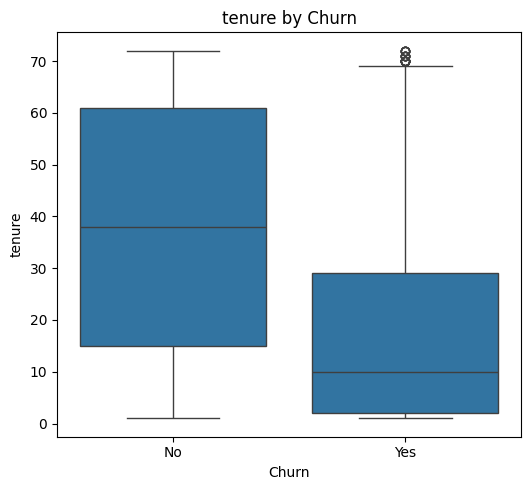

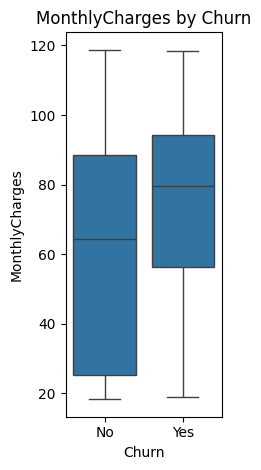

In [56]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(num_vars, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.tight_layout()
    plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_16244\3676566129.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='TotalCharges', data=df, palette='Set2', showfliers=True)


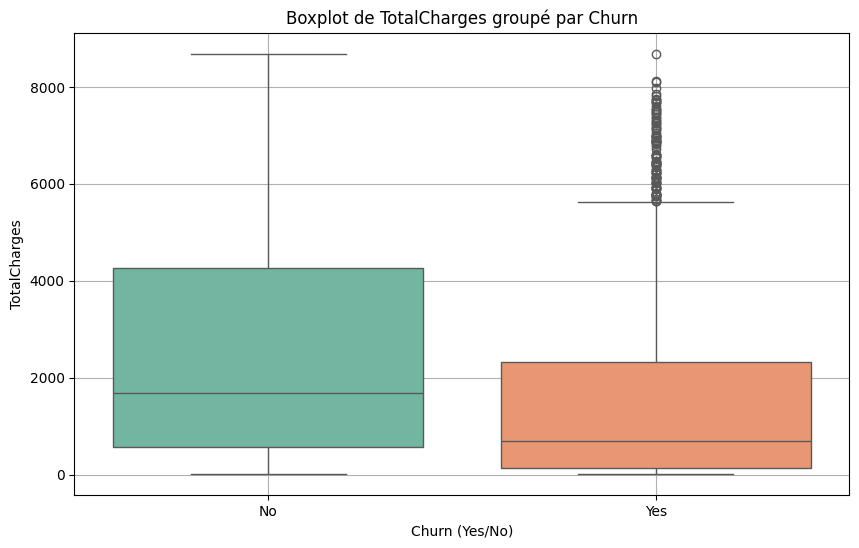

In [57]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convertir en float
df = df.dropna(subset=['TotalCharges'])  # Supprimer NaN

# Option 1 : Boxplot basique amélioré (avec groupement par Churn pour plus de sens)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df, palette='Set2', showfliers=True)
plt.title('Boxplot de TotalCharges groupé par Churn')
plt.xlabel('Churn (Yes/No)')
plt.ylabel('TotalCharges')
plt.grid(True)
plt.show()

*2.4.2. Influence des variables cartégorielles sur le Churn*

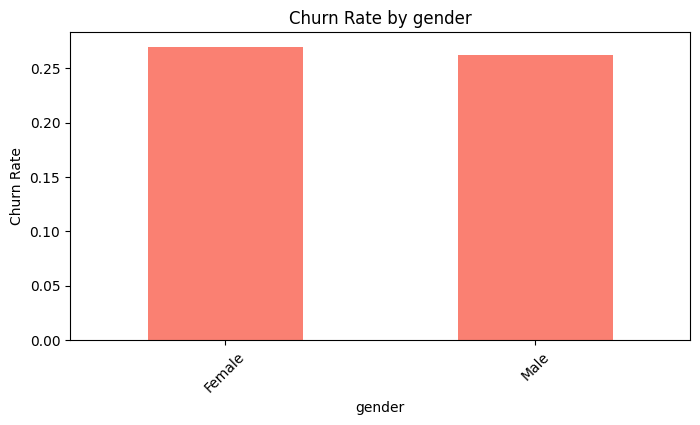

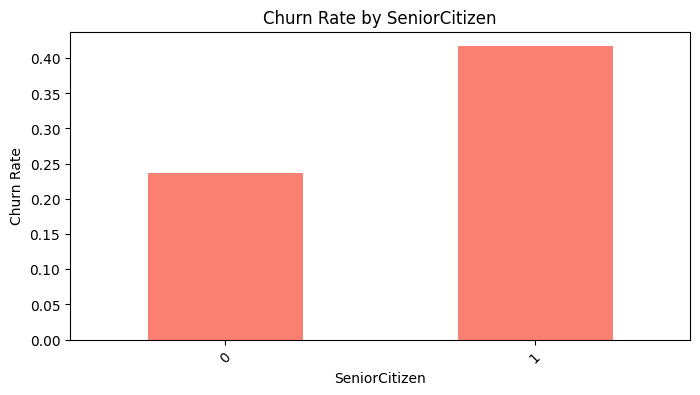

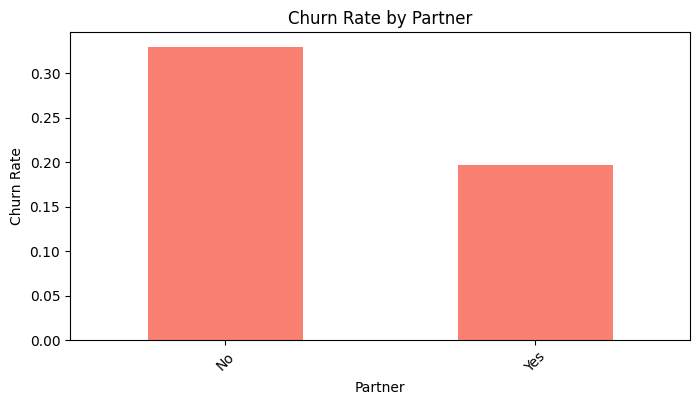

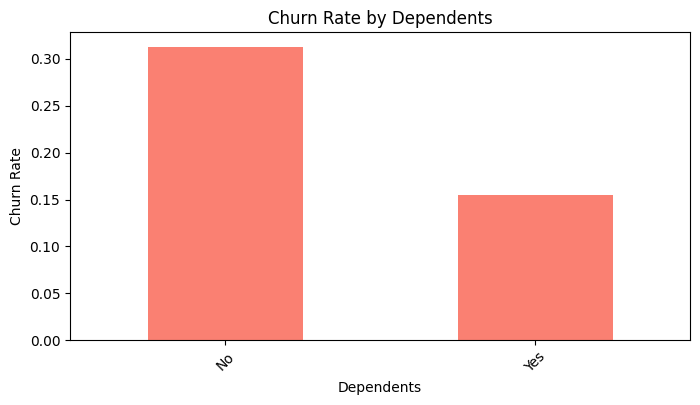

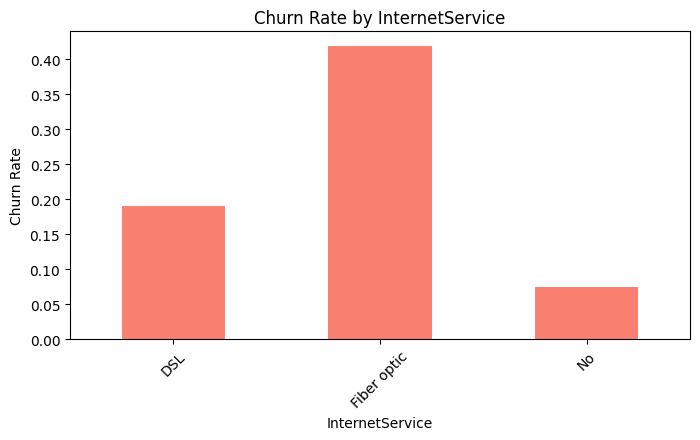

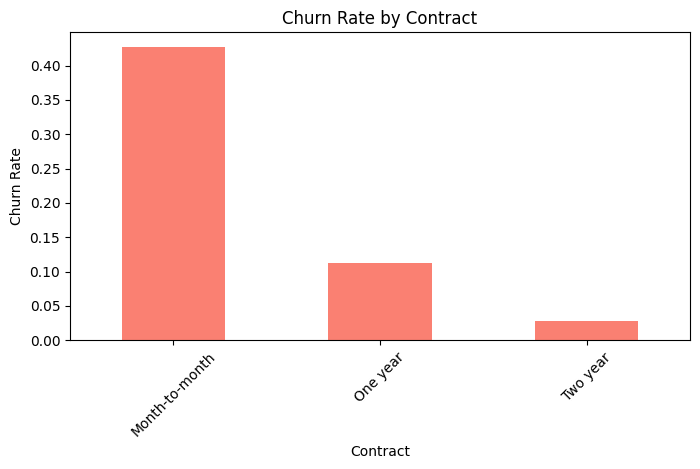

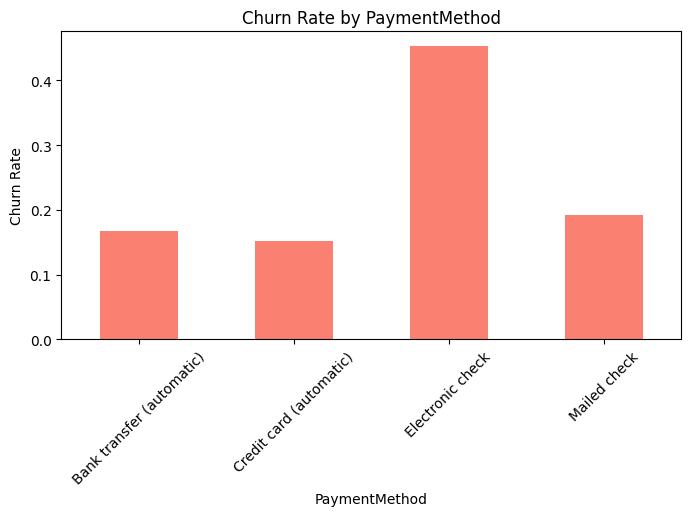

In [58]:
for col in categorical_cols:
    churn_rate = df.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)['Yes']
    plt.figure(figsize=(8, 4))
    churn_rate.plot(kind='bar', color='salmon')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=45)
    plt.show()

**------------ -------------**

***3. Prétraitement des données***

**3.1. Nettoyage des données**

*3.1.1. Suppression de la colonne 'customer ID'*

In [59]:
df = df.drop(['customerID'], axis=1)

In [60]:
print("Nombre de valeurs manquantes par colonne:\n", df.isnull().sum())

Nombre de valeurs manquantes par colonne:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


⚠️ Aucune des colonnes contient des valeurs manquantes, MAIS les valeurs manquantes sont affichées en type int64 et pourtant des colonnes tel que 'TotalCharges' utilisent des strings et peuvent contenir des strings vides ' '⚠️

In [61]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [62]:
print("Nombre de valeurs manquantes par colonne:\n", df.isnull().sum())

Nombre de valeurs manquantes par colonne:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


❌ La colonne 'TotalCharges' contient 11 NaNs

In [63]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [64]:
print("Valeurs manquantes aprés nettoyage:\n", df.isnull().sum())

Valeurs manquantes aprés nettoyage:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


✅ Et voila le travail !

**3.2. Normalisation et Scaling**

In [65]:
X = df.drop('Churn', axis=1)
y = df['Churn']
scaler = StandardScaler()
X[num_vars] = scaler.fit_transform(X[num_vars])

**3.3. Encodage**

*3.3.1 Encodage des valeurs categorielles en numériques binaires*

In [66]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                'PaperlessBilling', 'Churn']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

*3.3.1 Encodage des valeurs categorielles multi-classes en numériques (OneHotEncoder)*

In [67]:
multi_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection','TechSupport',
               'StreamingTV', 'StreamingMovies', 'Contract', 
                              'PaymentMethod']
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)  

In [68]:
print("Données après encodage:\n", df.head())

Données après encodage:
    gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0            False                            False            False   
1            

In [69]:
print("Types des données après encodage:\n", df.dtypes)
print()
print("Dimensions des données après encodage:", df.shape)

Types des données après encodage:
 gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes              

**3.4. PCA**

In [70]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df.drop('Churn', axis=1))

In [71]:
print("Nombre de composantes PCA:", pca.n_components_)
print("Ratio de variance expliquée par chaque composante:", pca.explained_variance_ratio_)

Nombre de composantes PCA: 1
Ratio de variance expliquée par chaque composante: [0.9998604]


**3.5. Divsion du Dataset (Training /Test)**

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
print("Taille du jeu d'entraînement:", X_train.shape)
print("Taille du jeu de test:", X_test.shape)

Taille du jeu d'entraînement: (5625, 1)
Taille du jeu de test: (1407, 1)


**------------ -------------**

***4. Validation Croisée***

In [73]:
models = {
    'KNN': KNeighborsClassifier(),  
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    print(f"---- {name} ----")

---- KNN ----
---- Naive Bayes ----
---- Decision Tree ----
---- Random Forest ----


**4.1. Validation Croisée avec k=5**

In [74]:
cv5_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"CV = 5 Scores: {cv5_scores}")
print(f"CV5 Mean Accuracy: {cv5_scores.mean():.4f}")

CV = 5 Scores: [0.65333333 0.63822222 0.62577778 0.63822222 0.62133333]
CV5 Mean Accuracy: 0.6354


**4.2. Validation Croisée avec k=10**

In [75]:
cv10_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
print(f"CV = 10 Scores: {cv10_scores}")
print(f"CV10 Mean Accuracy: {cv10_scores.mean():.4f}")

CV = 10 Scores: [0.62522202 0.65008881 0.65541741 0.64831261 0.60923623 0.6316726
 0.63879004 0.65480427 0.64946619 0.60676157]
CV10 Mean Accuracy: 0.6370


**------------ -------------**

***5. Application des algorithmes de Machine Learning***

In [76]:
import time

models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),  
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

predictions = {}
trained_models = {}

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    trained_models[name] = model
    predictions[name] = y_pred

    acc = accuracy_score(y_test ,y_pred)
    print(f"{name}: Accuracy = {acc:.2f}, Training Time = {train_time:.4f} seconds")

K-Nearest Neighbors: Accuracy = 0.71, Training Time = 0.0191 seconds
Naive Bayes: Accuracy = 0.73, Training Time = 0.0094 seconds
Decision Tree: Accuracy = 0.63, Training Time = 0.0513 seconds
Random Forest: Accuracy = 0.63, Training Time = 1.9764 seconds


**------------ -------------**

***6. Evaluation des Performances***

In [77]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score','AUC'])

In [78]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [79]:
# Enhanced Performance Metrics Function
def evaluate_model_comprehensive(model, X_test, y_test, model_name, stage=''):
    from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                                   f1_score, roc_auc_score, roc_curve, 
                                   confusion_matrix, classification_report,
                                   matthews_corrcoef, cohen_kappa_score)
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label='Yes', zero_division=0)
    rec = recall_score(y_test, y_pred, pos_label='Yes', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='Yes', zero_division=0)
    
    # Métriques supplémentaires
    spec = recall_score(y_test, y_pred, pos_label='No', zero_division=0)  # Specificity
    mcc = matthews_corrcoef(y_test, y_pred)  # Matthews Correlation Coefficient
    kappa = cohen_kappa_score(y_test, y_pred)  # Cohen's Kappa
    
    cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{'='*60}")
    print(f"{stage} {model_name} - Detailed Metrics")
    print(f"{'='*60}")
    print(f"Accuracy:    {acc:.4f}")
    print(f"Precision:   {prec:.4f}")
    print(f"Recall:      {rec:.4f}")
    print(f"Specificity: {spec:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"MCC:         {mcc:.4f}")
    print(f"Kappa:       {kappa:.4f}")
    print(f"\nConfusion Matrix Components:")
    print(f"True Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")
    
    fig = plt.figure(figsize=(15, 5))
    
    #Confusion Matrix
    ax1 = plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                cbar_kws={'label': 'Count'})
    plt.title(f'{stage} {model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)
    
    #Normalized Confusion Matrix
    ax2 = plt.subplot(1, 3, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                vmin=0, vmax=1, cbar_kws={'label': 'Proportion'})
    plt.title(f'{stage} {model_name}\nNormalized Confusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)
    
    # ROC Curve
    ax3 = plt.subplot(1, 3, 3)
    if hasattr(model, 'predict_proba'):
        if hasattr(model, 'classes_'):
            classes_list = list(model.classes_)
            yes_idx = classes_list.index('Yes') if 'Yes' in classes_list else 1
        else:
            yes_idx = 1
        
        y_prob = model.predict_proba(X_test)[:, yes_idx]
        y_test_bin = (y_test == 'Yes').astype(int)
        
        fpr, tpr, thresholds = roc_curve(y_test_bin, y_prob)
        auc = roc_auc_score(y_test_bin, y_prob)
        
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        plt.fill_between(fpr, tpr, alpha=0.3)
        plt.xlabel('False Positive Rate', fontsize=10)
        plt.ylabel('True Positive Rate', fontsize=10)
        plt.title(f'{stage} {model_name}\nROC Curve', fontsize=12, fontweight='bold')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
    else:
        auc = np.nan
        plt.text(0.5, 0.5, 'No probability\npredictions available', 
                ha='center', va='center', fontsize=12)
        plt.title(f'{stage} {model_name}\nROC Curve', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No', 'Yes'], zero_division=0))
    
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'Specificity': spec,
        'F1-Score': f1,
        'AUC': auc,
        'MCC': mcc,
        'Kappa': kappa,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }



BASELINE MODEL EVALUATION - COMPREHENSIVE ANALYSIS

Baseline K-Nearest Neighbors - Detailed Metrics
Accuracy:    0.7143
Precision:   0.4426
Recall:      0.2888
Specificity: 0.8683
F1-Score:    0.3495
MCC:         0.1833
Kappa:       0.1767

Confusion Matrix Components:
True Negatives:  897
False Positives: 136
False Negatives: 266
True Positives:  108


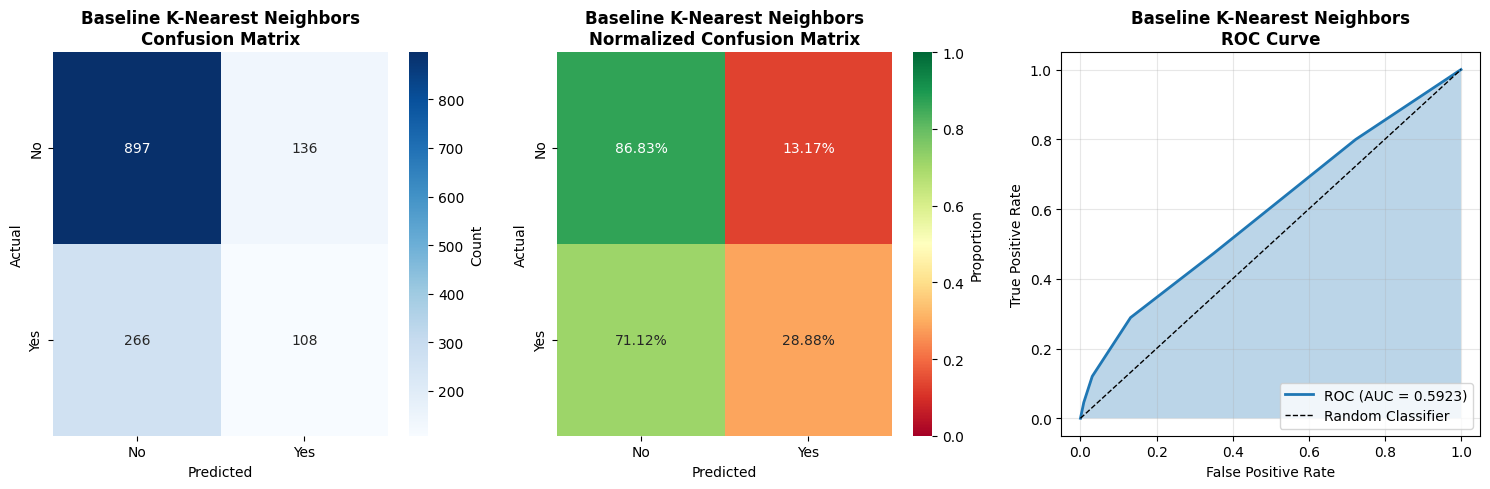


Classification Report:
              precision    recall  f1-score   support

          No       0.77      0.87      0.82      1033
         Yes       0.44      0.29      0.35       374

    accuracy                           0.71      1407
   macro avg       0.61      0.58      0.58      1407
weighted avg       0.68      0.71      0.69      1407


Baseline Naive Bayes - Detailed Metrics
Accuracy:    0.7342
Precision:   0.0000
Recall:      0.0000
Specificity: 1.0000
F1-Score:    0.0000
MCC:         0.0000
Kappa:       0.0000

Confusion Matrix Components:
True Negatives:  1033
False Positives: 0
False Negatives: 374
True Positives:  0


C:\Users\PC\AppData\Local\Temp\ipykernel_16244\595338114.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([metrics])], ignore_index=True)


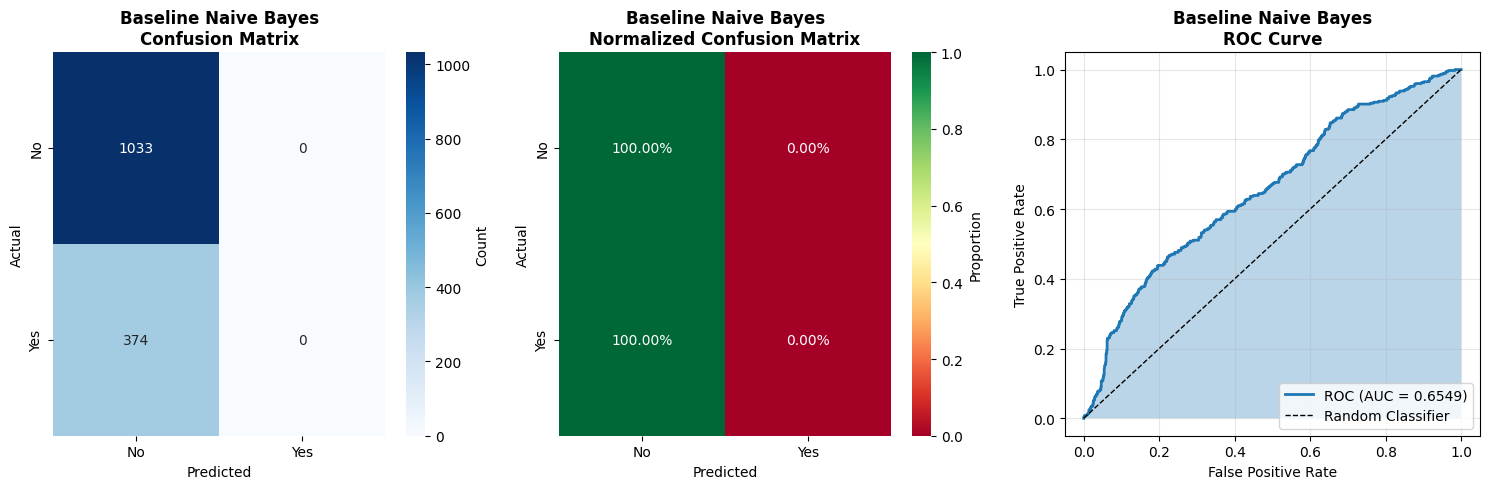


Classification Report:
              precision    recall  f1-score   support

          No       0.73      1.00      0.85      1033
         Yes       0.00      0.00      0.00       374

    accuracy                           0.73      1407
   macro avg       0.37      0.50      0.42      1407
weighted avg       0.54      0.73      0.62      1407


Baseline Decision Tree - Detailed Metrics
Accuracy:    0.6304
Precision:   0.3220
Recall:      0.3529
Specificity: 0.7309
F1-Score:    0.3367
MCC:         0.0815
Kappa:       0.0813

Confusion Matrix Components:
True Negatives:  755
False Positives: 278
False Negatives: 242
True Positives:  132


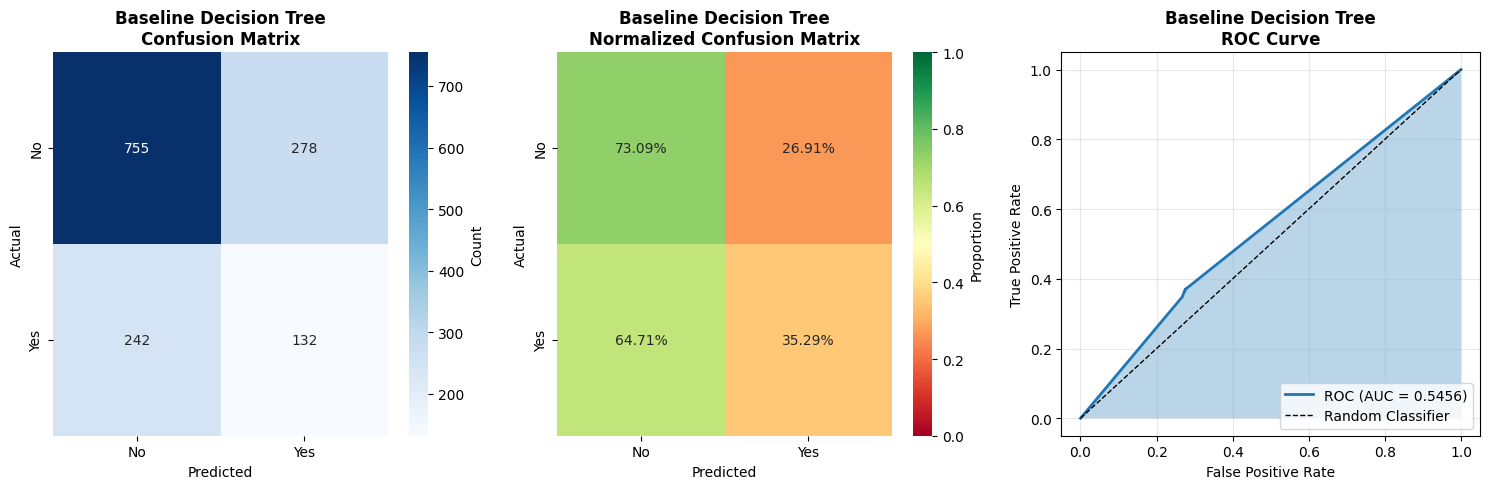


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.73      0.74      1033
         Yes       0.32      0.35      0.34       374

    accuracy                           0.63      1407
   macro avg       0.54      0.54      0.54      1407
weighted avg       0.64      0.63      0.64      1407


Baseline Random Forest - Detailed Metrics
Accuracy:    0.6311
Precision:   0.3245
Recall:      0.3583
Specificity: 0.7299
F1-Score:    0.3405
MCC:         0.0856
Kappa:       0.0854

Confusion Matrix Components:
True Negatives:  754
False Positives: 279
False Negatives: 240
True Positives:  134


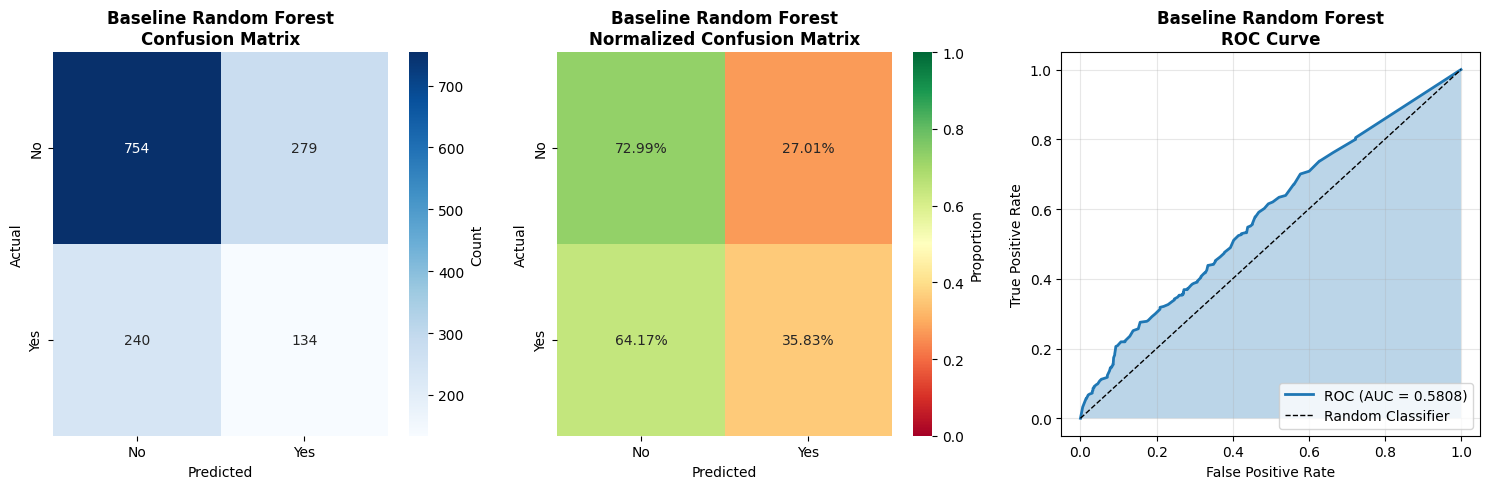


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.73      0.74      1033
         Yes       0.32      0.36      0.34       374

    accuracy                           0.63      1407
   macro avg       0.54      0.54      0.54      1407
weighted avg       0.64      0.63      0.64      1407


BASELINE MODELS - SUMMARY TABLE
                 Model  Accuracy  Precision  Recall  Specificity  F1-Score  \
0  K-Nearest Neighbors    0.7143     0.4426  0.2888       0.8683    0.3495   
1          Naive Bayes    0.7342     0.0000  0.0000       1.0000    0.0000   
2        Decision Tree    0.6304     0.3220  0.3529       0.7309    0.3367   
3        Random Forest    0.6311     0.3245  0.3583       0.7299    0.3405   

      AUC     MCC   Kappa   TP    TN   FP   FN  
0  0.5923  0.1833  0.1767  108   897  136  266  
1  0.6549  0.0000  0.0000    0  1033    0  374  
2  0.5456  0.0815  0.0813  132   755  278  242  
3  0.5808  0.0856  0.0854  13

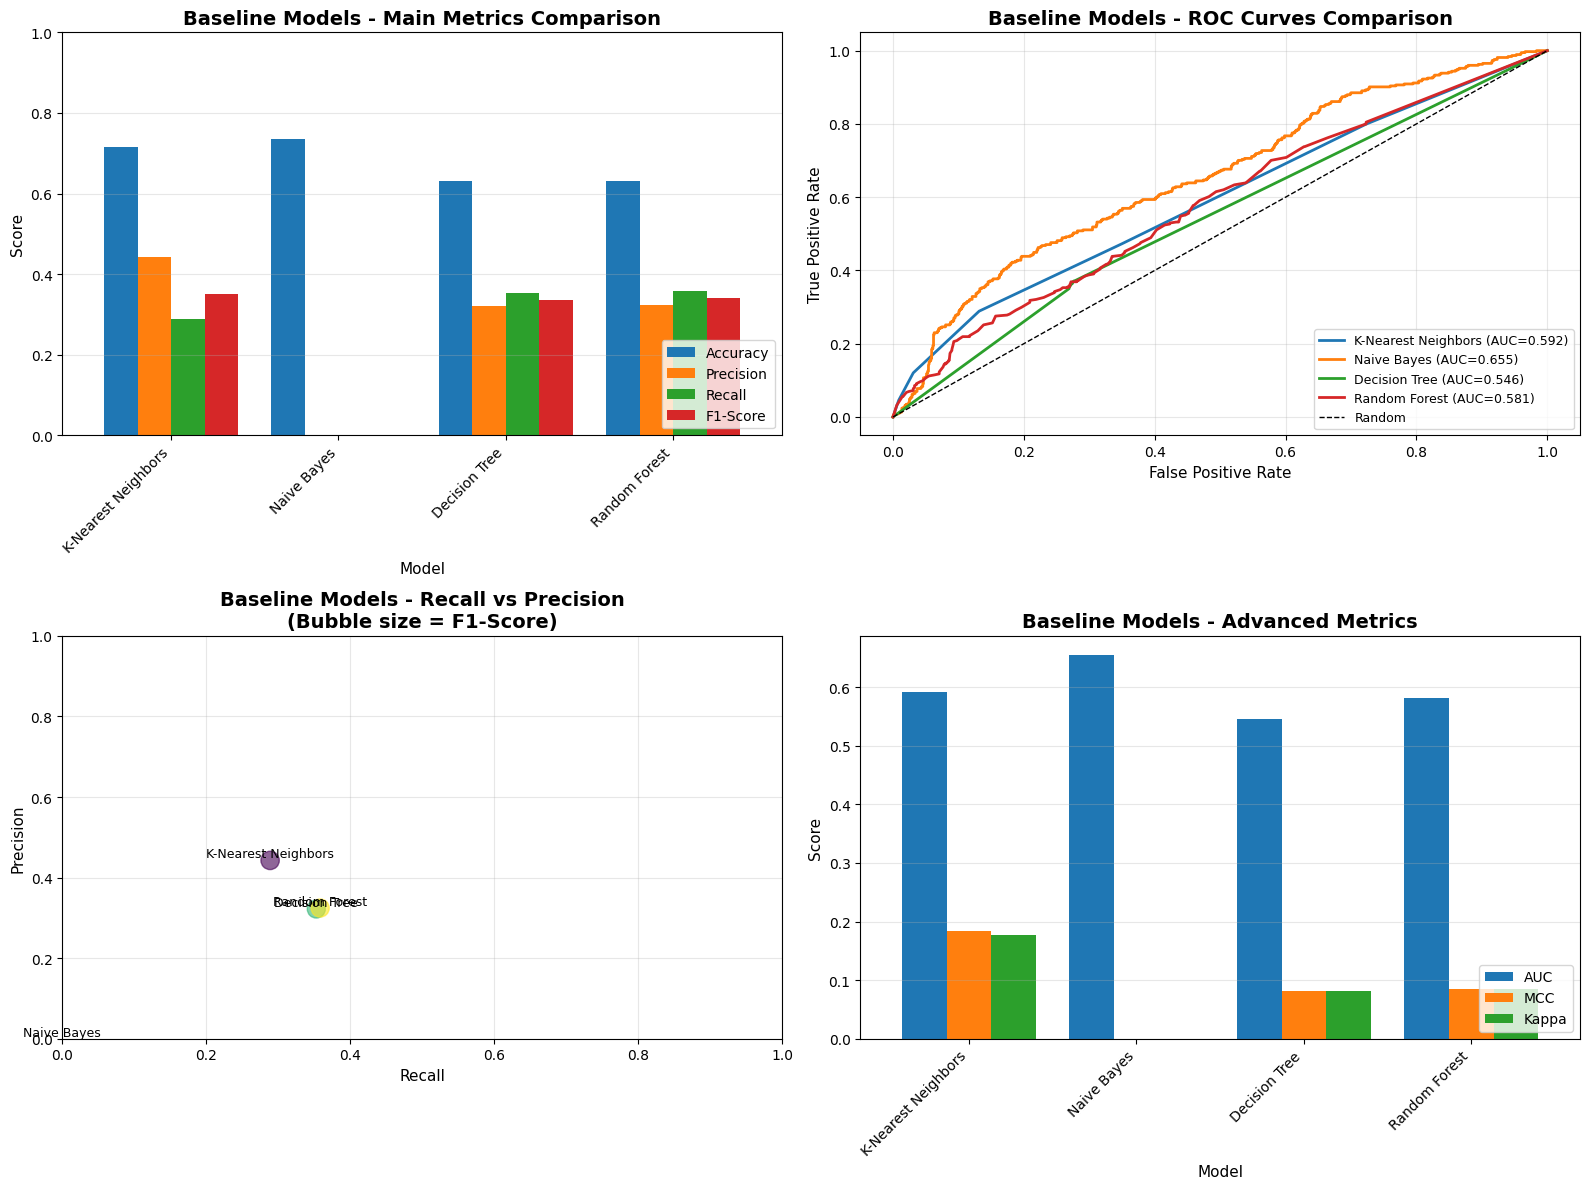


✓ Baseline evaluation completed with comprehensive metrics and visualizations


In [ ]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity',
                                'F1-Score', 'AUC', 'MCC', 'Kappa', 'TP', 'TN', 'FP', 'FN'])

print("\n" + "="*80)
print("BASELINE MODEL EVALUATION - COMPREHENSIVE ANALYSIS")
print("="*80)

for name in trained_models.keys():
    model = trained_models[name]
    metrics = evaluate_model_comprehensive(model, X_test, y_test, name, stage='Baseline')
    results = pd.concat([results, pd.DataFrame([metrics])], ignore_index=True)

print("\n" + "="*80)
print("BASELINE MODELS - SUMMARY TABLE")
print("="*80)
print(results.round(4))

results_sorted = results.sort_values('F1-Score', ascending=False)
print("\n" + "="*80)
print("MODELS RANKED BY F1-SCORE")
print("="*80)
print(results_sorted[['Model', 'F1-Score', 'Recall', 'Precision', 'AUC']].round(4))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Comparaison des métriques principales
ax1 = axes[0, 0]
metrics_plot = results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].set_index('Model')
metrics_plot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Baseline Models - Main Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score', fontsize=11)
ax1.set_xlabel('Model', fontsize=11)
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Comparaison des courbes ROC
ax2 = axes[0, 1]
for name in trained_models.keys():
    model = trained_models[name]
    if hasattr(model, 'predict_proba'):
        if hasattr(model, 'classes_'):
            classes_list = list(model.classes_)
            yes_idx = classes_list.index('Yes') if 'Yes' in classes_list else 1
        else:
            yes_idx = 1
        
        y_prob = model.predict_proba(X_test)[:, yes_idx]
        y_test_bin = (y_test == 'Yes').astype(int)
        
        from sklearn.metrics import roc_curve, roc_auc_score
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
        auc = roc_auc_score(y_test_bin, y_prob)
        
        ax2.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('Baseline Models - ROC Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Recall vs Precision 
ax3 = axes[1, 0]
scatter = ax3.scatter(results['Recall'], results['Precision'], 
                      s=results['F1-Score']*500, alpha=0.6, c=range(len(results)), cmap='viridis')
for idx, row in results.iterrows():
    ax3.annotate(row['Model'], (row['Recall'], row['Precision']), 
                fontsize=9, ha='center', va='bottom')
ax3.set_xlabel('Recall', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_title('Baseline Models - Recall vs Precision\n(Bubble size = F1-Score)', 
             fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

# Plot 4: Comparaison des métriques avancées
ax4 = axes[1, 1]
advanced_metrics = results[['Model', 'AUC', 'MCC', 'Kappa']].set_index('Model')
advanced_metrics.plot(kind='bar', ax=ax4, width=0.8)
ax4.set_title('Baseline Models - Advanced Metrics', fontsize=14, fontweight='bold')
ax4.set_ylabel('Score', fontsize=11)
ax4.set_xlabel('Model', fontsize=11)
ax4.legend(loc='lower right')
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n✓ Baseline evaluation completed with comprehensive metrics and visualizations")


In [81]:
print("Model Performance Summary:\n", results)
results.to_csv('base_model.csv' ,index=False)

Model Performance Summary:
                  Model  Accuracy  Precision    Recall  Specificity  F1-Score  \
0  K-Nearest Neighbors  0.714286   0.442623  0.288770     0.868345  0.349515   
1          Naive Bayes  0.734186   0.000000  0.000000     1.000000  0.000000   
2        Decision Tree  0.630419   0.321951  0.352941     0.730881  0.336735   
3        Random Forest  0.631130   0.324455  0.358289     0.729913  0.340534   

        AUC       MCC     Kappa   TP    TN   FP   FN  
0  0.592272  0.183323  0.176707  108   897  136  266  
1  0.654937  0.000000  0.000000    0  1033    0  374  
2  0.545585  0.081490  0.081325  132   755  278  242  
3  0.580821  0.085565  0.085362  134   754  279  240  


**------------ -------------**

***7. Optimisation des hyperparamétres avec GridSearch***

**7.1. Définition des paramétres**

In [82]:
param_grids = {
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    },
    'Decision Tree': {
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

In [83]:
tuned_models = {}
tuned_predictions = {}
tuned_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])

plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>


HYPERPARAMETER TUNING - COMPREHENSIVE ANALYSIS

Tuning K-Nearest Neighbors...


c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(



Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best CV F1-Score: nan
Tuning Time: 16.22s

Tuned K-Nearest Neighbors - Detailed Metrics
Accuracy:    0.6901
Precision:   0.3931
Recall:      0.3048
Specificity: 0.8296
F1-Score:    0.3434
MCC:         0.1468
Kappa:       0.1448

Confusion Matrix Components:
True Negatives:  857
False Positives: 176
False Negatives: 260
True Positives:  114


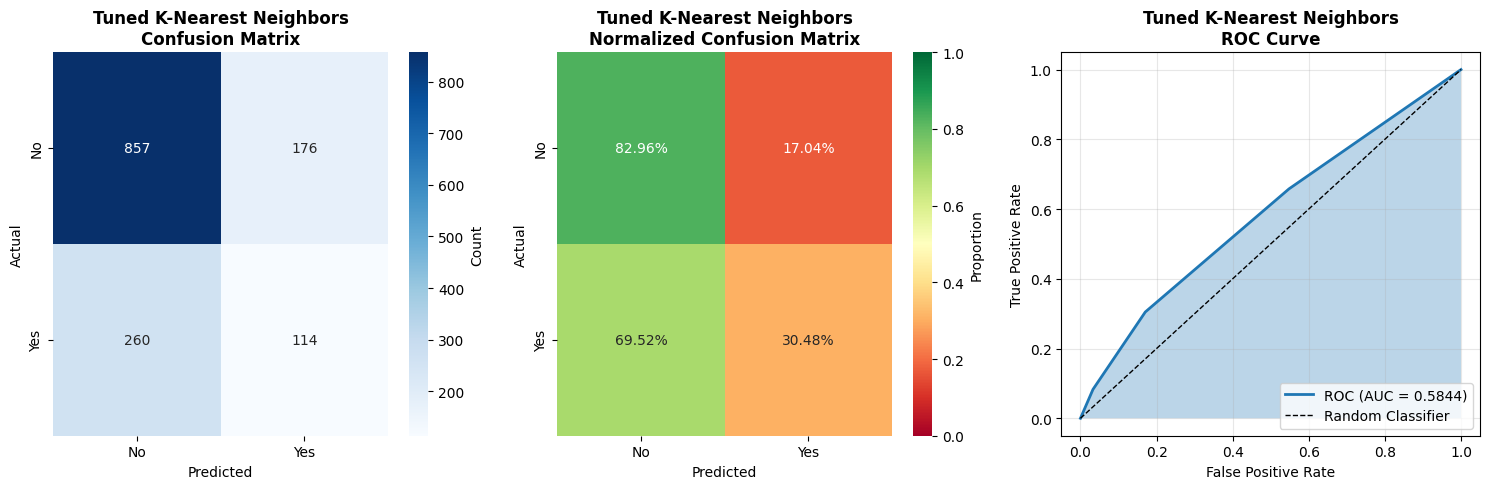


Classification Report:
              precision    recall  f1-score   support

          No       0.77      0.83      0.80      1033
         Yes       0.39      0.30      0.34       374

    accuracy                           0.69      1407
   macro avg       0.58      0.57      0.57      1407
weighted avg       0.67      0.69      0.68      1407


Tuning Naive Bayes...


C:\Users\PC\AppData\Local\Temp\ipykernel_16244\1775211999.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tuned_results = pd.concat([tuned_results, pd.DataFrame([metrics])], ignore_index=True)
c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(



Best Parameters: {'var_smoothing': 1e-09}
Best CV F1-Score: nan
Tuning Time: 0.29s

Tuned Naive Bayes - Detailed Metrics
Accuracy:    0.7342
Precision:   0.0000
Recall:      0.0000
Specificity: 1.0000
F1-Score:    0.0000
MCC:         0.0000
Kappa:       0.0000

Confusion Matrix Components:
True Negatives:  1033
False Positives: 0
False Negatives: 374
True Positives:  0


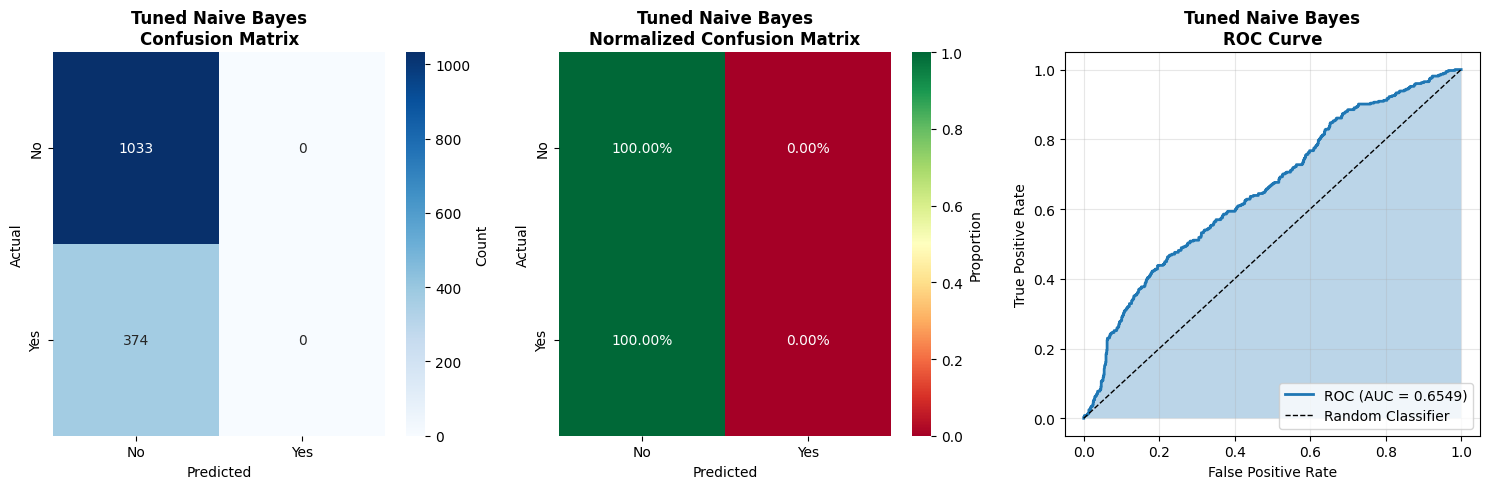


Classification Report:
              precision    recall  f1-score   support

          No       0.73      1.00      0.85      1033
         Yes       0.00      0.00      0.00       374

    accuracy                           0.73      1407
   macro avg       0.37      0.50      0.42      1407
weighted avg       0.54      0.73      0.62      1407


Tuning Decision Tree...


c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1-Score: nan
Tuning Time: 3.57s

Tuned Decision Tree - Detailed Metrics
Accuracy:    0.6304
Precision:   0.3220
Recall:      0.3529
Specificity: 0.7309
F1-Score:    0.3367
MCC:         0.0815
Kappa:       0.0813

Confusion Matrix Components:
True Negatives:  755
False Positives: 278
False Negatives: 242
True Positives:  132


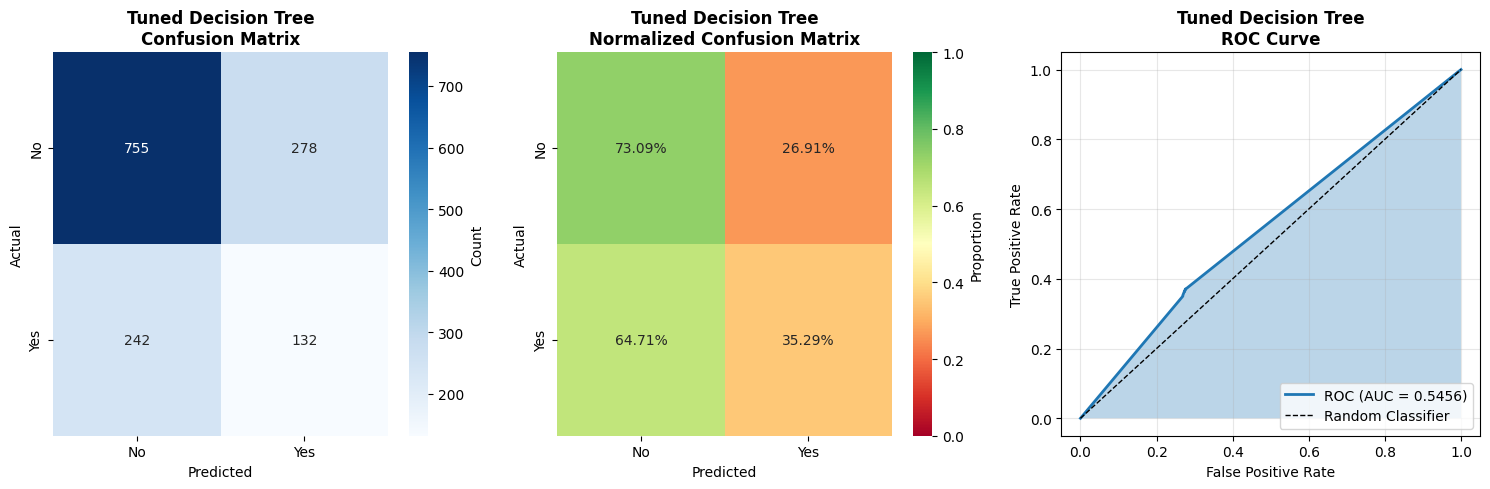


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.73      0.74      1033
         Yes       0.32      0.35      0.34       374

    accuracy                           0.63      1407
   macro avg       0.54      0.54      0.54      1407
weighted avg       0.64      0.63      0.64      1407


Tuning Random Forest...


c:\Users\PC\OneDrive\Desktop\DAMI_Project\dami-proj\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV F1-Score: nan
Tuning Time: 123.64s

Tuned Random Forest - Detailed Metrics
Accuracy:    0.6326
Precision:   0.3260
Recall:      0.3583
Specificity: 0.7318
F1-Score:    0.3414
MCC:         0.0876
Kappa:       0.0874

Confusion Matrix Components:
True Negatives:  756
False Positives: 277
False Negatives: 240
True Positives:  134


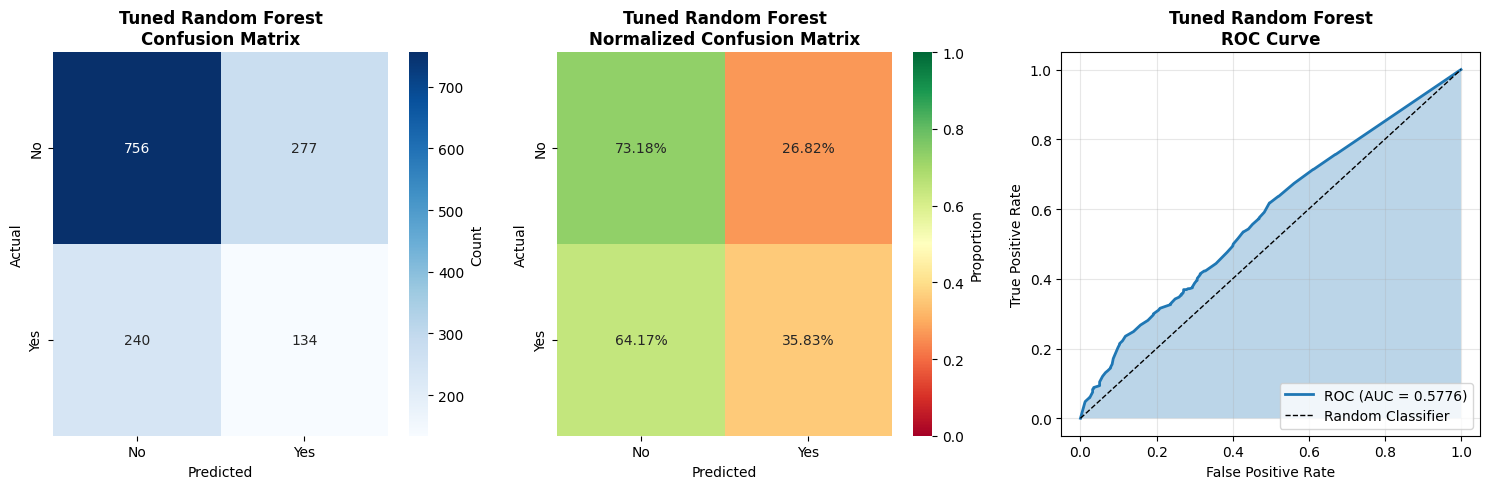


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.73      0.75      1033
         Yes       0.33      0.36      0.34       374

    accuracy                           0.63      1407
   macro avg       0.54      0.55      0.54      1407
weighted avg       0.64      0.63      0.64      1407


TUNED MODELS - SUMMARY TABLE
                 Model  Accuracy  Precision  Recall  Specificity  F1-Score  \
0  K-Nearest Neighbors    0.6901     0.3931  0.3048       0.8296    0.3434   
1          Naive Bayes    0.7342     0.0000  0.0000       1.0000    0.0000   
2        Decision Tree    0.6304     0.3220  0.3529       0.7309    0.3367   
3        Random Forest    0.6326     0.3260  0.3583       0.7318    0.3414   

      AUC     MCC   Kappa   TP    TN   FP   FN  
0  0.5844  0.1468  0.1448  114   857  176  260  
1  0.6549  0.0000  0.0000    0  1033    0  374  
2  0.5456  0.0815  0.0813  132   755  278  242  
3  0.5776  0.0876  0.0874  134  

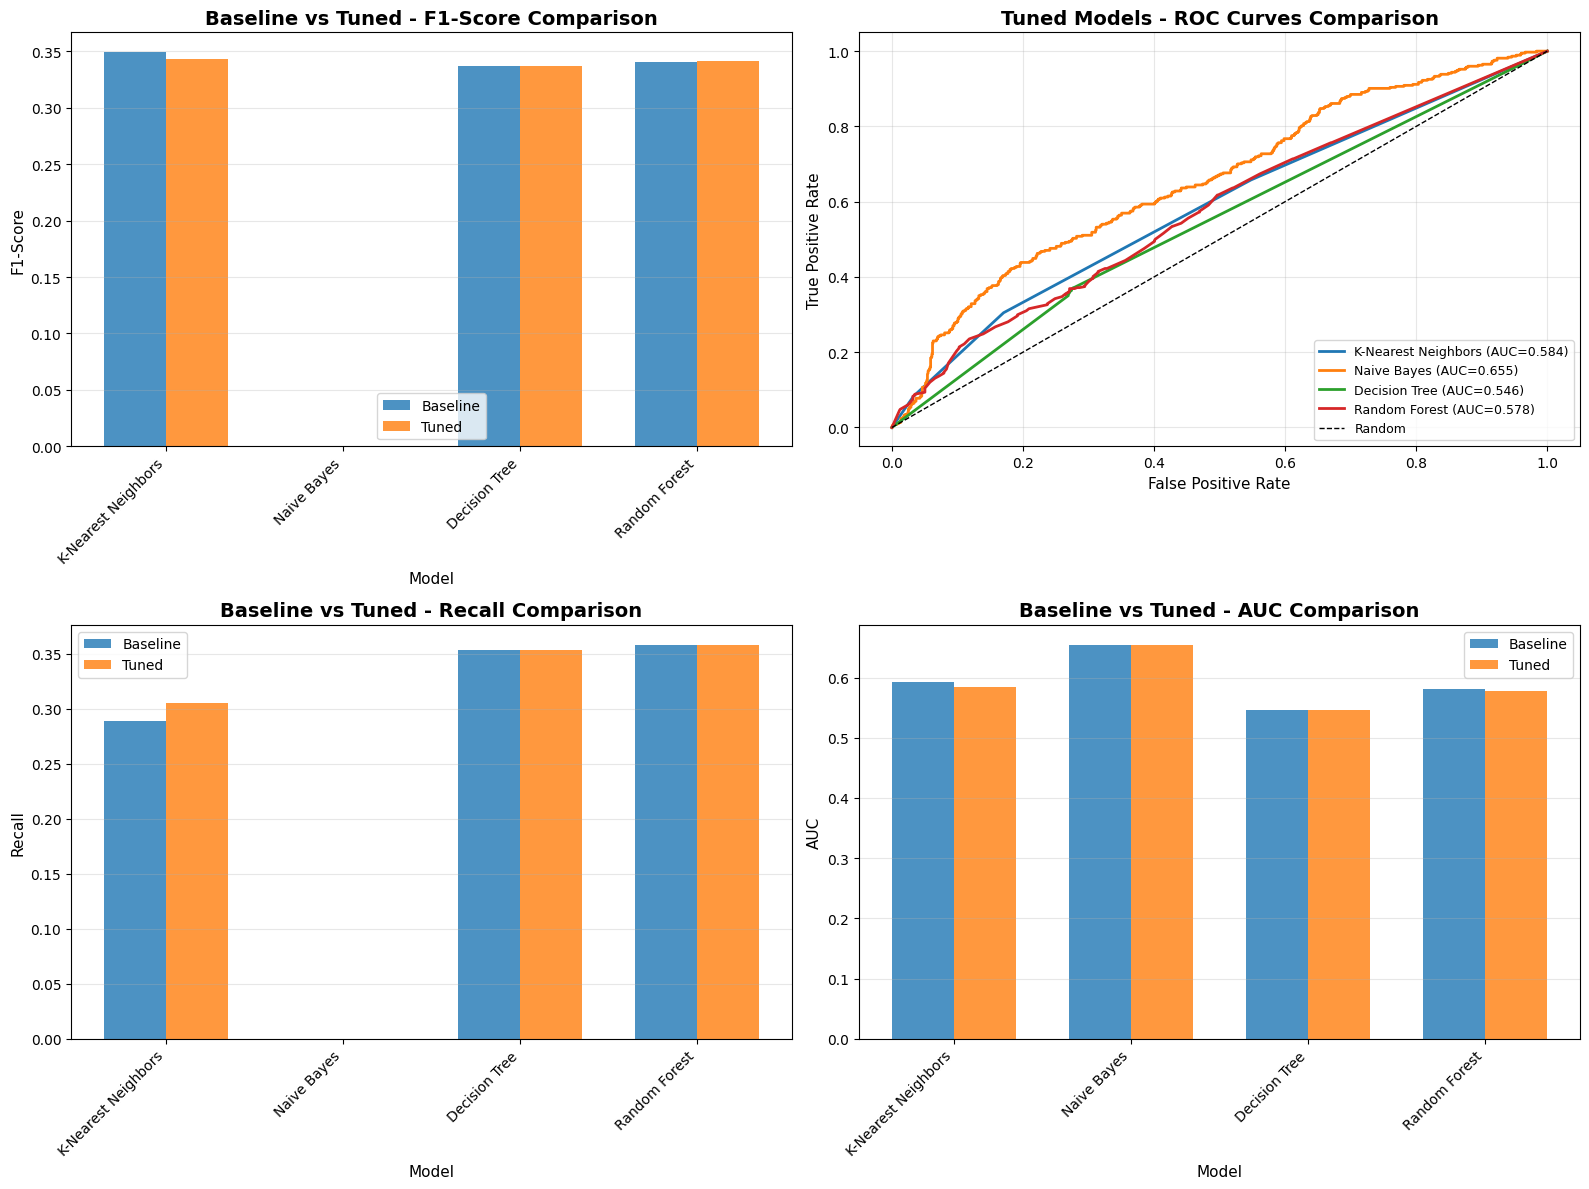


✓ Hyperparameter tuning completed with comprehensive metrics and comparisons


In [ ]:
import time

tuned_models = {}
tuned_predictions = {}
tuned_results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity',
                                      'F1-Score', 'AUC', 'MCC', 'Kappa', 'TP', 'TN', 'FP', 'FN'])

print("\n" + "="*80)
print("HYPERPARAMETER TUNING - COMPREHENSIVE ANALYSIS")
print("="*80)

for name in models.keys():
    # Grid Search
    grid = GridSearchCV(estimator=models[name], param_grid=param_grids[name], 
                       cv=5, scoring='f1', n_jobs=-1, verbose=0)
    start_time = time.time()
    grid.fit(X_train, y_train)
    tune_time = time.time() - start_time
    
    print(f"\nBest Parameters: {grid.best_params_}")
    print(f"Best CV F1-Score: {grid.best_score_:.4f}")
    print(f"Tuning Time: {tune_time:.2f}s")
    
    best_model = grid.best_estimator_
    tuned_models[name] = best_model
    
    metrics = evaluate_model_comprehensive(best_model, X_test, y_test, name, stage='Tuned')
    tuned_results = pd.concat([tuned_results, pd.DataFrame([metrics])], ignore_index=True)

# Résultats affichage des modèles ajustés
print("\n" + "="*80)
print("TUNED MODELS - SUMMARY TABLE")
print("="*80)
print(tuned_results.round(4))

# Comparer baseline vs tuned 
print("\n" + "="*80)
print("BASELINE VS TUNED COMPARISON")
print("="*80)

comparison_df = pd.DataFrame()
for model_name in results['Model'].unique():
    baseline_row = results[results['Model'] == model_name].iloc[0]
    tuned_row = tuned_results[tuned_results['Model'] == model_name].iloc[0]
    
    improvement = {
        'Model': model_name,
        'Baseline F1': baseline_row['F1-Score'],
        'Tuned F1': tuned_row['F1-Score'],
        'F1 Improvement': tuned_row['F1-Score'] - baseline_row['F1-Score'],
        'Baseline AUC': baseline_row['AUC'],
        'Tuned AUC': tuned_row['AUC'],
        'AUC Improvement': tuned_row['AUC'] - baseline_row['AUC']
    }
    comparison_df = pd.concat([comparison_df, pd.DataFrame([improvement])], ignore_index=True)

print(comparison_df.round(4))

# Visualisation: Baseline vs Tuned 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: F1-Score Comparison
ax1 = axes[0, 0]
x = np.arange(len(results['Model']))
width = 0.35
ax1.bar(x - width/2, results['F1-Score'], width, label='Baseline', alpha=0.8)
ax1.bar(x + width/2, tuned_results['F1-Score'], width, label='Tuned', alpha=0.8)
ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('F1-Score', fontsize=11)
ax1.set_title('Baseline vs Tuned - F1-Score Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: ROC Curves - Tuned Models
ax2 = axes[0, 1]
for name in tuned_models.keys():
    model = tuned_models[name]
    if hasattr(model, 'predict_proba'):
        if hasattr(model, 'classes_'):
            classes_list = list(model.classes_)
            yes_idx = classes_list.index('Yes') if 'Yes' in classes_list else 1
        else:
            yes_idx = 1
        
        y_prob = model.predict_proba(X_test)[:, yes_idx]
        y_test_bin = (y_test == 'Yes').astype(int)
        
        from sklearn.metrics import roc_curve, roc_auc_score
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
        auc = roc_auc_score(y_test_bin, y_prob)
        
        ax2.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('Tuned Models - ROC Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Recall Improvement
ax3 = axes[1, 0]
ax3.bar(x - width/2, results['Recall'], width, label='Baseline', alpha=0.8)
ax3.bar(x + width/2, tuned_results['Recall'], width, label='Tuned', alpha=0.8)
ax3.set_xlabel('Model', fontsize=11)
ax3.set_ylabel('Recall', fontsize=11)
ax3.set_title('Baseline vs Tuned - Recall Comparison', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(results['Model'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: AUC Improvement
ax4 = axes[1, 1]
ax4.bar(x - width/2, results['AUC'], width, label='Baseline', alpha=0.8)
ax4.bar(x + width/2, tuned_results['AUC'], width, label='Tuned', alpha=0.8)
ax4.set_xlabel('Model', fontsize=11)
ax4.set_ylabel('AUC', fontsize=11)
ax4.set_title('Baseline vs Tuned - AUC Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(results['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_16244\2370034149.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


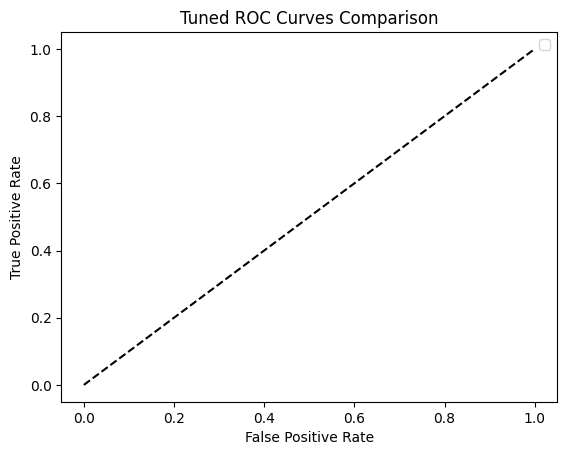


Baseline vs Tuned Comparison:
                      Accuracy_Baseline  Precision_Baseline  Recall_Baseline  \
Model                                                                         
K-Nearest Neighbors           0.714286            0.442623         0.288770   
Naive Bayes                   0.734186            0.000000         0.000000   
Decision Tree                 0.630419            0.321951         0.352941   
Random Forest                 0.631130            0.324455         0.358289   

                     Specificity_Baseline  F1-Score_Baseline  AUC_Baseline  \
Model                                                                        
K-Nearest Neighbors              0.868345           0.349515      0.592272   
Naive Bayes                      1.000000           0.000000      0.654937   
Decision Tree                    0.730881           0.336735      0.545585   
Random Forest                    0.729913           0.340534      0.580821   

                     MCC

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned ROC Curves Comparison')
plt.legend()
plt.show()

# Compare baseline vs tuned 
comparison = pd.merge(results.set_index('Model'), tuned_results.set_index('Model'), left_index=True, right_index=True, suffixes=('_Baseline', '_Tuned'))
print("\nBaseline vs Tuned Comparison:\n", comparison)

tuned_results.to_csv('tuned_results.csv', index=False)
comparison.to_csv('comparison_baseline_tuned.csv')

**------------ -------------**

***8. Application des différentes techniques de réequilibrage***

In [86]:
rebalancers = {
    'SMOTE': SMOTE(random_state=42),
    'Oversampling': RandomOverSampler(random_state=42),
    'Undersampling': RandomUnderSampler(random_state=42)
}

In [87]:
resampled_data = {}

for rb_name, rebalancer in rebalancers.items():
    print(f"==== APPLICATION DU {rb_name} ====")
    start_time = time.time()
    X_res, y_res = rebalancer.fit_resample(X_train, y_train)
    res_time = time.time() - start_time
    
    resampled_data[rb_name] = (X_res, y_res)
    
    # Check balance
    print(f"Resampled shapes: X {X_res.shape}, y distribution:\n{y_res.value_counts(normalize=True) * 100}")
    print(f"Resampling Time: {res_time:.4f}s")
    print(f"==== FIN DU {rb_name} ====")
    print()

==== APPLICATION DU SMOTE ====
Resampled shapes: X (8260, 1), y distribution:
Churn
No     50.0
Yes    50.0
Name: proportion, dtype: float64
Resampling Time: 0.0429s
==== FIN DU SMOTE ====

==== APPLICATION DU Oversampling ====
Resampled shapes: X (8260, 1), y distribution:
Churn
No     50.0
Yes    50.0
Name: proportion, dtype: float64
Resampling Time: 0.0667s
==== FIN DU Oversampling ====

==== APPLICATION DU Undersampling ====
Resampled shapes: X (2990, 1), y distribution:
Churn
No     50.0
Yes    50.0
Name: proportion, dtype: float64
Resampling Time: 0.0610s
==== FIN DU Undersampling ====



**------------ -------------**

***9. Ré-calculation des performances*** 

In [88]:
rebalanced_results = pd.DataFrame(columns=['Rebalancer', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'])


CLASS REBALANCING EVALUATION - COMPREHENSIVE ANALYSIS

--------------------------------------------------------------------------------
REBALANCING TECHNIQUE: SMOTE
--------------------------------------------------------------------------------
Training set size: 8260
Class distribution: {'No': 4130, 'Yes': 4130}

------------------------------------------------------------
Training K-Nearest Neighbors with SMOTE...
------------------------------------------------------------
Training Time: 0.03s

SMOTE K-Nearest Neighbors - Detailed Metrics
Accuracy:    0.5707
Precision:   0.3102
Recall:      0.5027
Specificity: 0.5954
F1-Score:    0.3837
MCC:         0.0875
Kappa:       0.0818

Confusion Matrix Components:
True Negatives:  615
False Positives: 418
False Negatives: 186
True Positives:  188


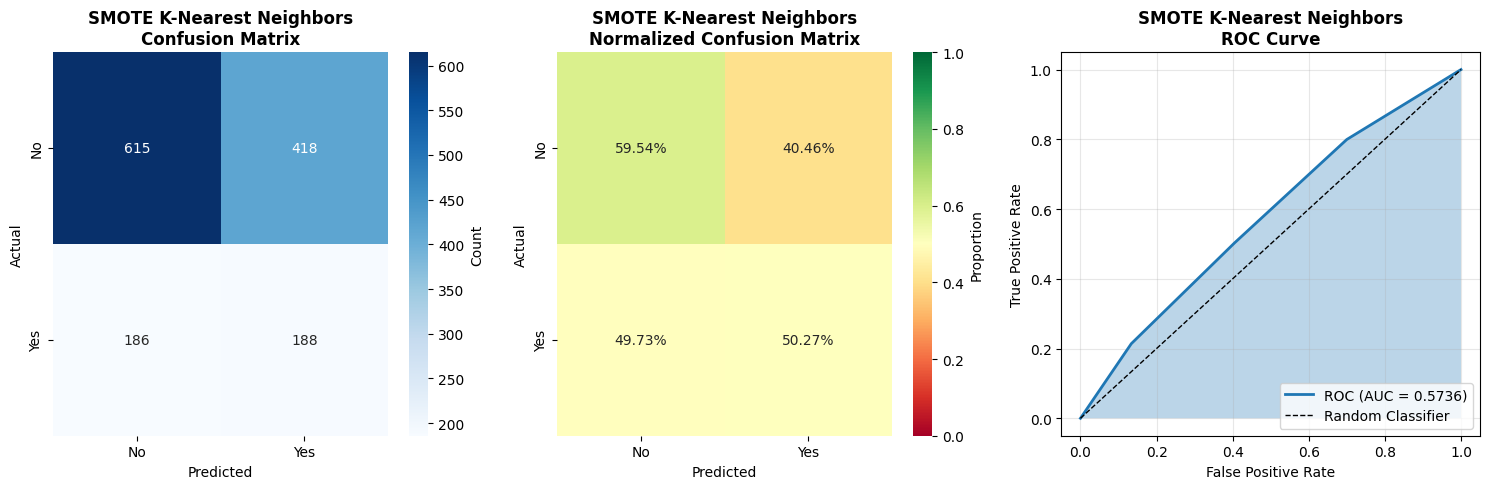


Classification Report:
              precision    recall  f1-score   support

          No       0.77      0.60      0.67      1033
         Yes       0.31      0.50      0.38       374

    accuracy                           0.57      1407
   macro avg       0.54      0.55      0.53      1407
weighted avg       0.65      0.57      0.59      1407


------------------------------------------------------------
Training Naive Bayes with SMOTE...
------------------------------------------------------------
Training Time: 0.02s

SMOTE Naive Bayes - Detailed Metrics
Accuracy:    0.4840
Precision:   0.3167
Recall:      0.8128
Specificity: 0.3650
F1-Score:    0.4558
MCC:         0.1687
Kappa:       0.1185

Confusion Matrix Components:
True Negatives:  377
False Positives: 656
False Negatives: 70
True Positives:  304


C:\Users\PC\AppData\Local\Temp\ipykernel_16244\2154234039.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rebalanced_results = pd.concat([rebalanced_results, pd.DataFrame([metrics])],


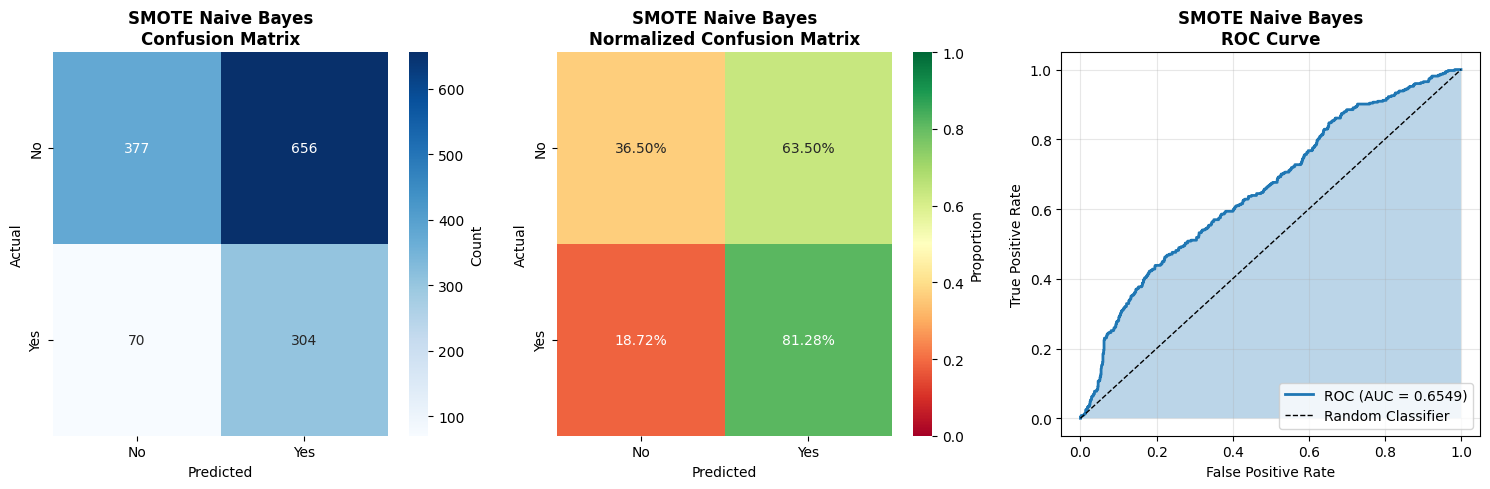


Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.36      0.51      1033
         Yes       0.32      0.81      0.46       374

    accuracy                           0.48      1407
   macro avg       0.58      0.59      0.48      1407
weighted avg       0.70      0.48      0.50      1407


------------------------------------------------------------
Training Decision Tree with SMOTE...
------------------------------------------------------------
Training Time: 0.07s

SMOTE Decision Tree - Detailed Metrics
Accuracy:    0.5636
Precision:   0.2993
Recall:      0.4786
Specificity: 0.5944
F1-Score:    0.3683
MCC:         0.0652
Kappa:       0.0613

Confusion Matrix Components:
True Negatives:  614
False Positives: 419
False Negatives: 195
True Positives:  179


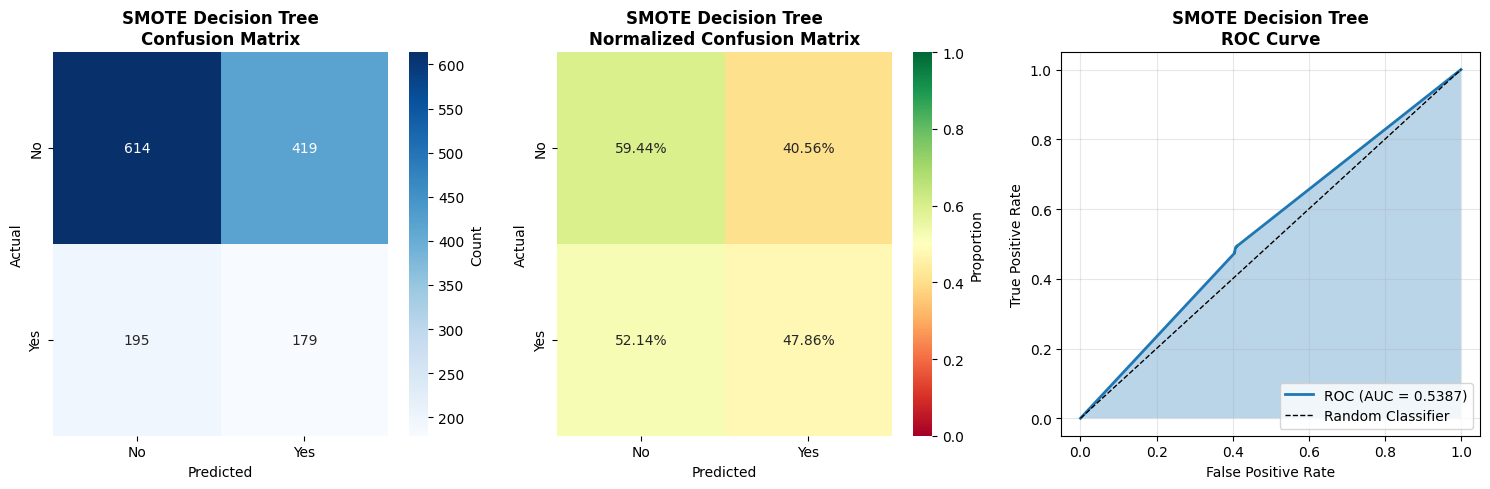


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.59      0.67      1033
         Yes       0.30      0.48      0.37       374

    accuracy                           0.56      1407
   macro avg       0.53      0.54      0.52      1407
weighted avg       0.64      0.56      0.59      1407


------------------------------------------------------------
Training Random Forest with SMOTE...
------------------------------------------------------------
Training Time: 1.73s

SMOTE Random Forest - Detailed Metrics
Accuracy:    0.5650
Precision:   0.3010
Recall:      0.4813
Specificity: 0.5954
F1-Score:    0.3704
MCC:         0.0685
Kappa:       0.0643

Confusion Matrix Components:
True Negatives:  615
False Positives: 418
False Negatives: 194
True Positives:  180


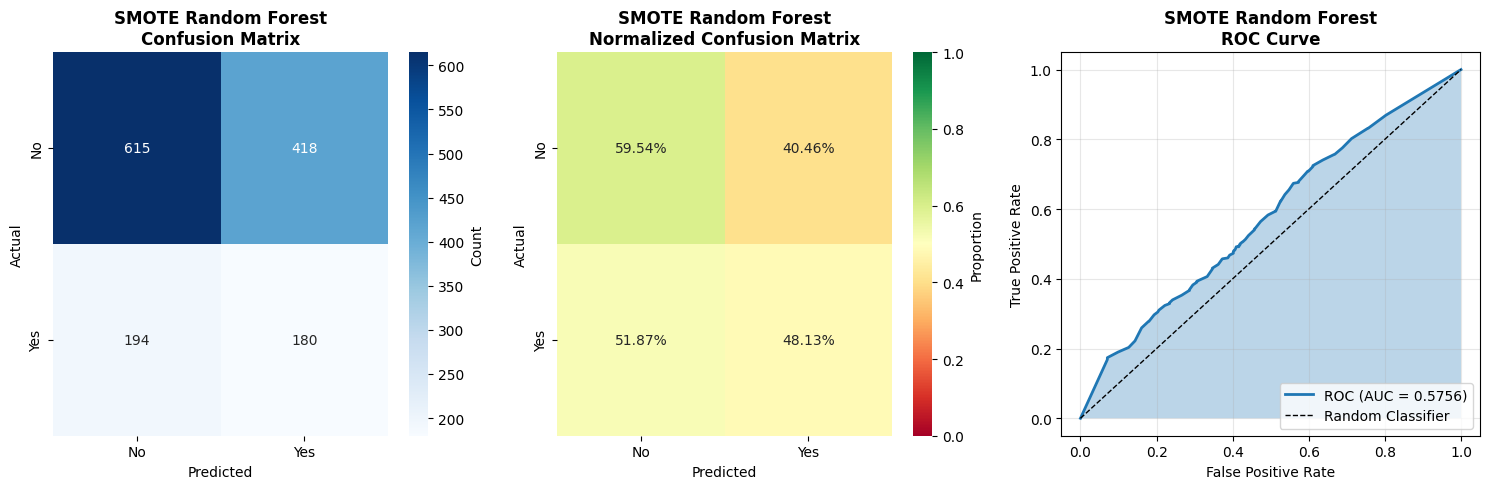


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.60      0.67      1033
         Yes       0.30      0.48      0.37       374

    accuracy                           0.57      1407
   macro avg       0.53      0.54      0.52      1407
weighted avg       0.64      0.57      0.59      1407


--------------------------------------------------------------------------------
REBALANCING TECHNIQUE: Oversampling
--------------------------------------------------------------------------------
Training set size: 8260
Class distribution: {'No': 4130, 'Yes': 4130}

------------------------------------------------------------
Training K-Nearest Neighbors with Oversampling...
------------------------------------------------------------
Training Time: 0.02s

Oversampling K-Nearest Neighbors - Detailed Metrics
Accuracy:    0.5842
Precision:   0.3178
Recall:      0.4920
Specificity: 0.6176
F1-Score:    0.3861
MCC:         0.0984
Kappa:       

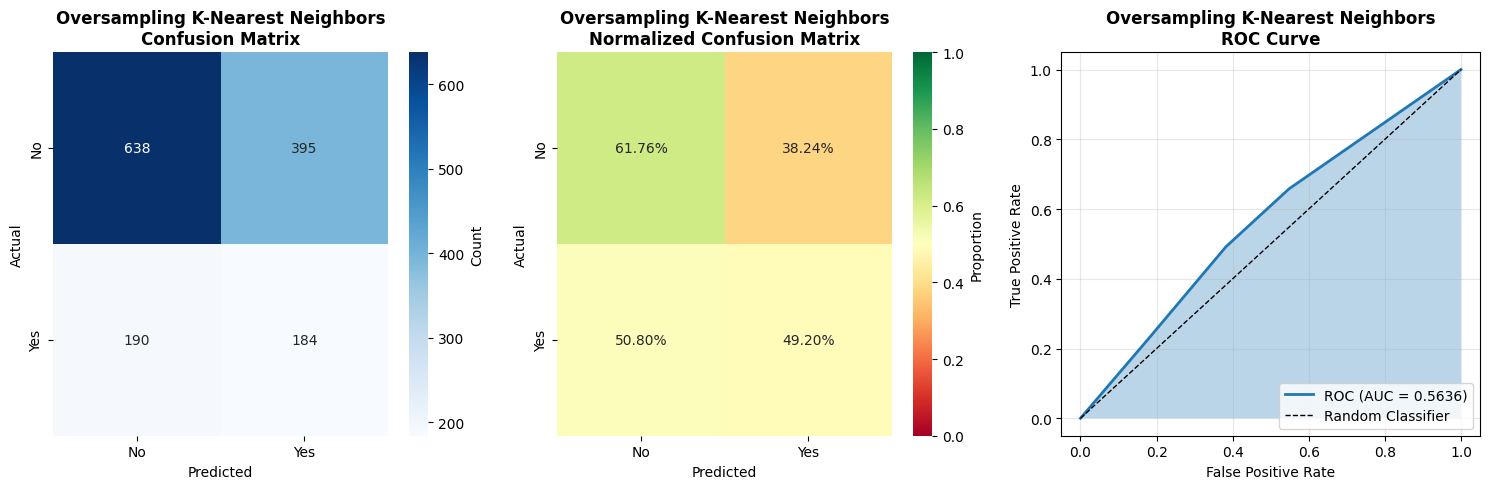


Classification Report:
              precision    recall  f1-score   support

          No       0.77      0.62      0.69      1033
         Yes       0.32      0.49      0.39       374

    accuracy                           0.58      1407
   macro avg       0.54      0.55      0.54      1407
weighted avg       0.65      0.58      0.61      1407


------------------------------------------------------------
Training Naive Bayes with Oversampling...
------------------------------------------------------------
Training Time: 0.02s

Oversampling Naive Bayes - Detailed Metrics
Accuracy:    0.4833
Precision:   0.3163
Recall:      0.8128
Specificity: 0.3640
F1-Score:    0.4554
MCC:         0.1679
Kappa:       0.1178

Confusion Matrix Components:
True Negatives:  376
False Positives: 657
False Negatives: 70
True Positives:  304


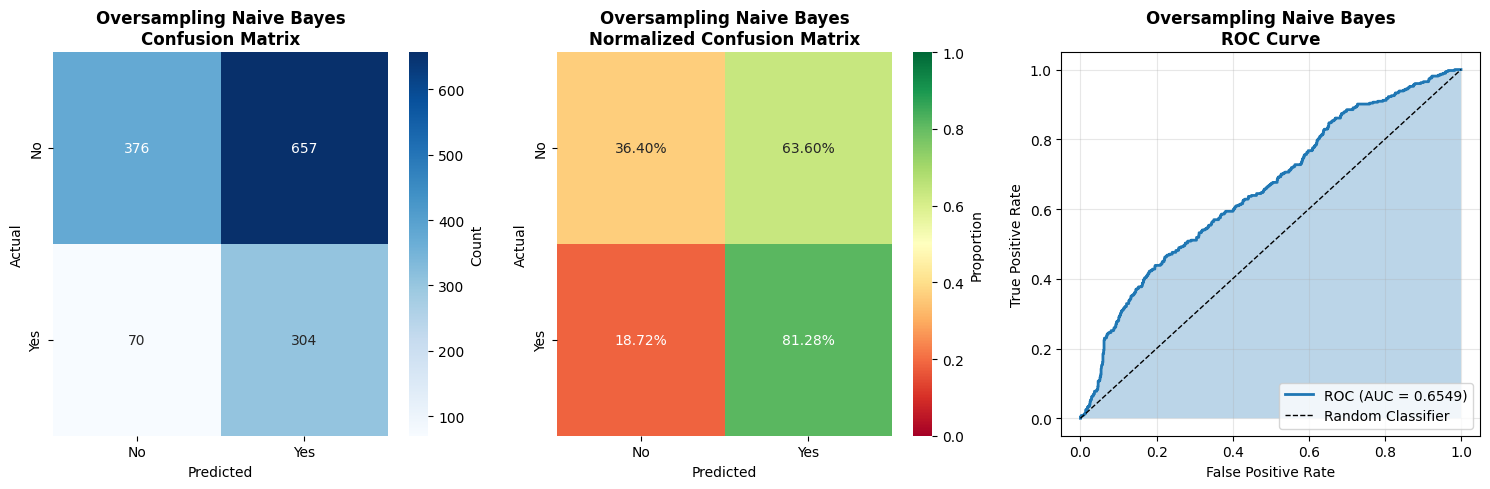


Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.36      0.51      1033
         Yes       0.32      0.81      0.46       374

    accuracy                           0.48      1407
   macro avg       0.58      0.59      0.48      1407
weighted avg       0.70      0.48      0.49      1407


------------------------------------------------------------
Training Decision Tree with Oversampling...
------------------------------------------------------------
Training Time: 0.05s

Oversampling Decision Tree - Detailed Metrics
Accuracy:    0.6311
Precision:   0.3286
Recall:      0.3717
Specificity: 0.7251
F1-Score:    0.3488
MCC:         0.0932
Kappa:       0.0929

Confusion Matrix Components:
True Negatives:  749
False Positives: 284
False Negatives: 235
True Positives:  139


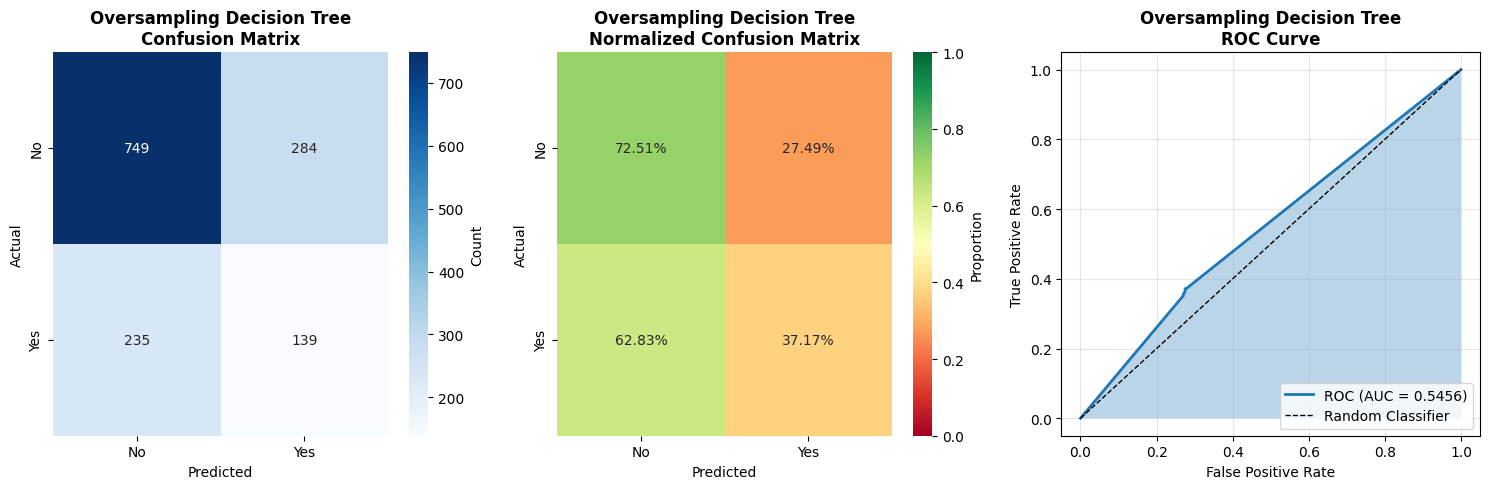


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.73      0.74      1033
         Yes       0.33      0.37      0.35       374

    accuracy                           0.63      1407
   macro avg       0.54      0.55      0.55      1407
weighted avg       0.65      0.63      0.64      1407


------------------------------------------------------------
Training Random Forest with Oversampling...
------------------------------------------------------------
Training Time: 1.16s

Oversampling Random Forest - Detailed Metrics
Accuracy:    0.6304
Precision:   0.3278
Recall:      0.3717
Specificity: 0.7241
F1-Score:    0.3484
MCC:         0.0922
Kappa:       0.0918

Confusion Matrix Components:
True Negatives:  748
False Positives: 285
False Negatives: 235
True Positives:  139


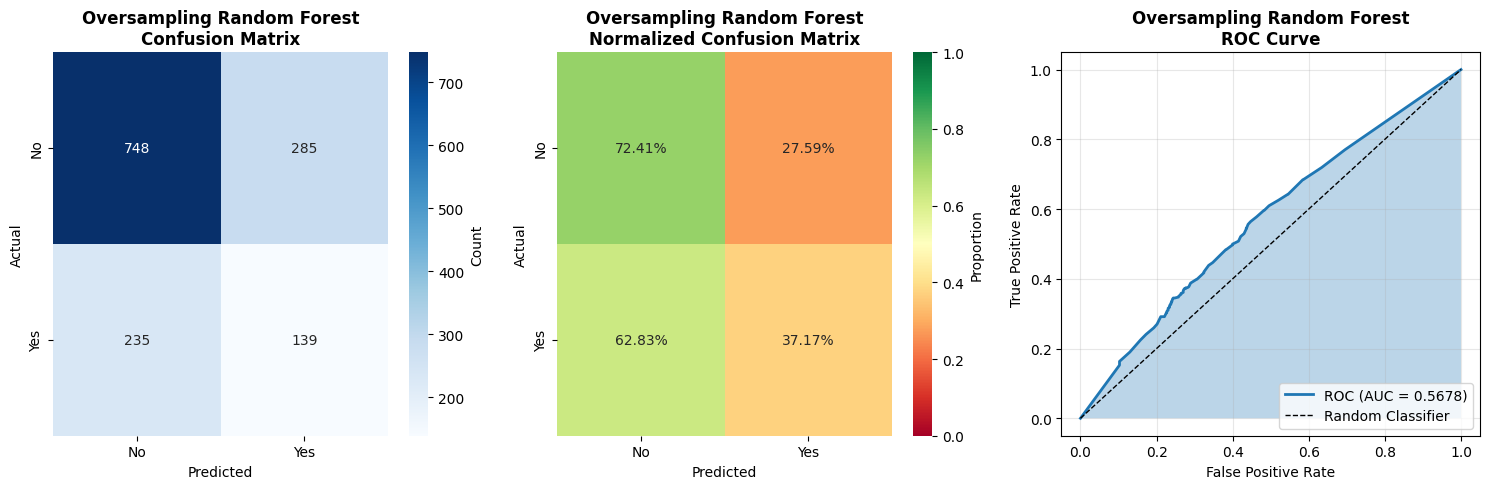


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.72      0.74      1033
         Yes       0.33      0.37      0.35       374

    accuracy                           0.63      1407
   macro avg       0.54      0.55      0.55      1407
weighted avg       0.65      0.63      0.64      1407


--------------------------------------------------------------------------------
REBALANCING TECHNIQUE: Undersampling
--------------------------------------------------------------------------------
Training set size: 2990
Class distribution: {'No': 1495, 'Yes': 1495}

------------------------------------------------------------
Training K-Nearest Neighbors with Undersampling...
------------------------------------------------------------
Training Time: 0.01s

Undersampling K-Nearest Neighbors - Detailed Metrics
Accuracy:    0.5565
Precision:   0.3117
Recall:      0.5535
Specificity: 0.5576
F1-Score:    0.3988
MCC:         0.0983
Kappa:    

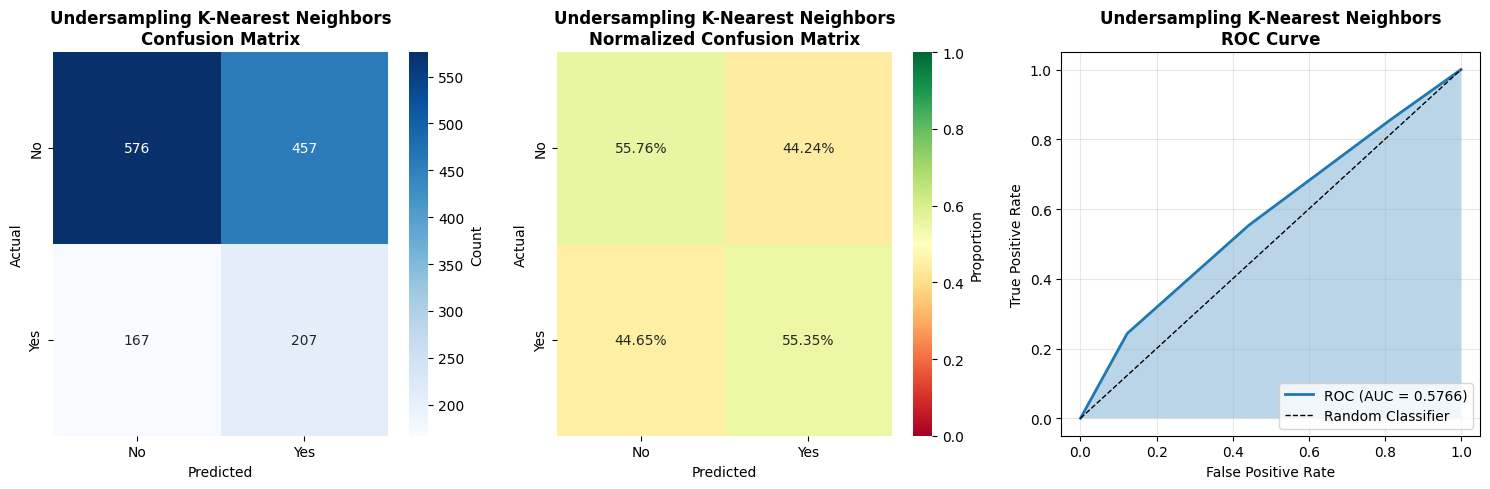


Classification Report:
              precision    recall  f1-score   support

          No       0.78      0.56      0.65      1033
         Yes       0.31      0.55      0.40       374

    accuracy                           0.56      1407
   macro avg       0.54      0.56      0.52      1407
weighted avg       0.65      0.56      0.58      1407


------------------------------------------------------------
Training Naive Bayes with Undersampling...
------------------------------------------------------------
Training Time: 0.01s

Undersampling Naive Bayes - Detailed Metrics
Accuracy:    0.4861
Precision:   0.3173
Recall:      0.8102
Specificity: 0.3688
F1-Score:    0.4560
MCC:         0.1693
Kappa:       0.1197

Confusion Matrix Components:
True Negatives:  381
False Positives: 652
False Negatives: 71
True Positives:  303


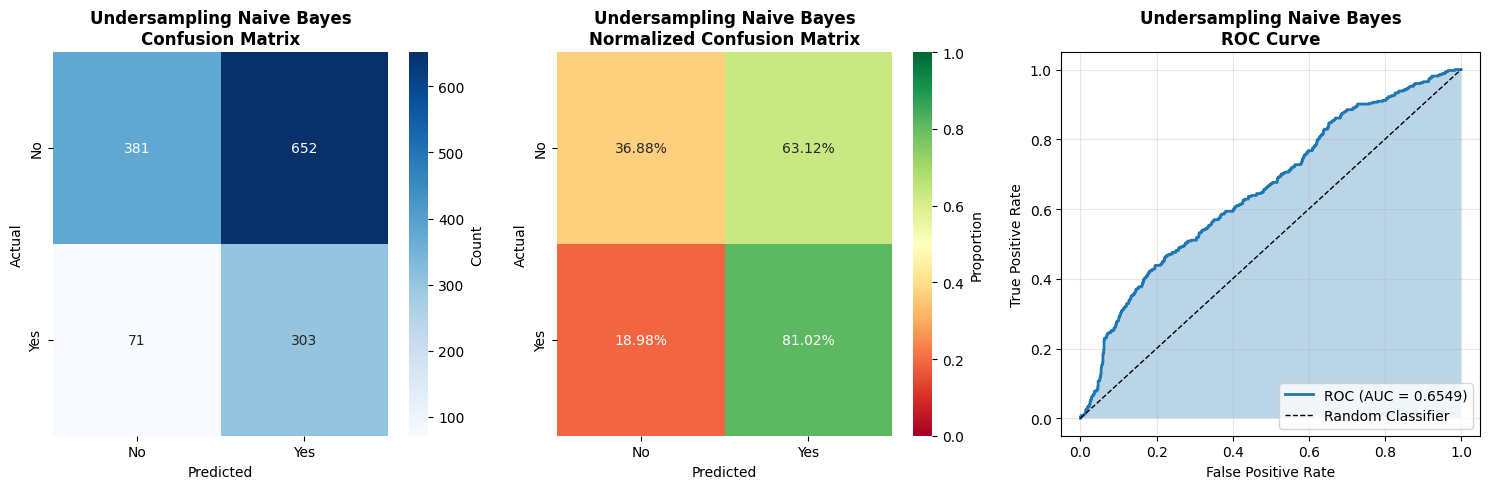


Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.37      0.51      1033
         Yes       0.32      0.81      0.46       374

    accuracy                           0.49      1407
   macro avg       0.58      0.59      0.48      1407
weighted avg       0.70      0.49      0.50      1407


------------------------------------------------------------
Training Decision Tree with Undersampling...
------------------------------------------------------------
Training Time: 0.02s

Undersampling Decision Tree - Detailed Metrics
Accuracy:    0.5345
Precision:   0.2949
Recall:      0.5401
Specificity: 0.5324
F1-Score:    0.3815
MCC:         0.0641
Kappa:       0.0573

Confusion Matrix Components:
True Negatives:  550
False Positives: 483
False Negatives: 172
True Positives:  202


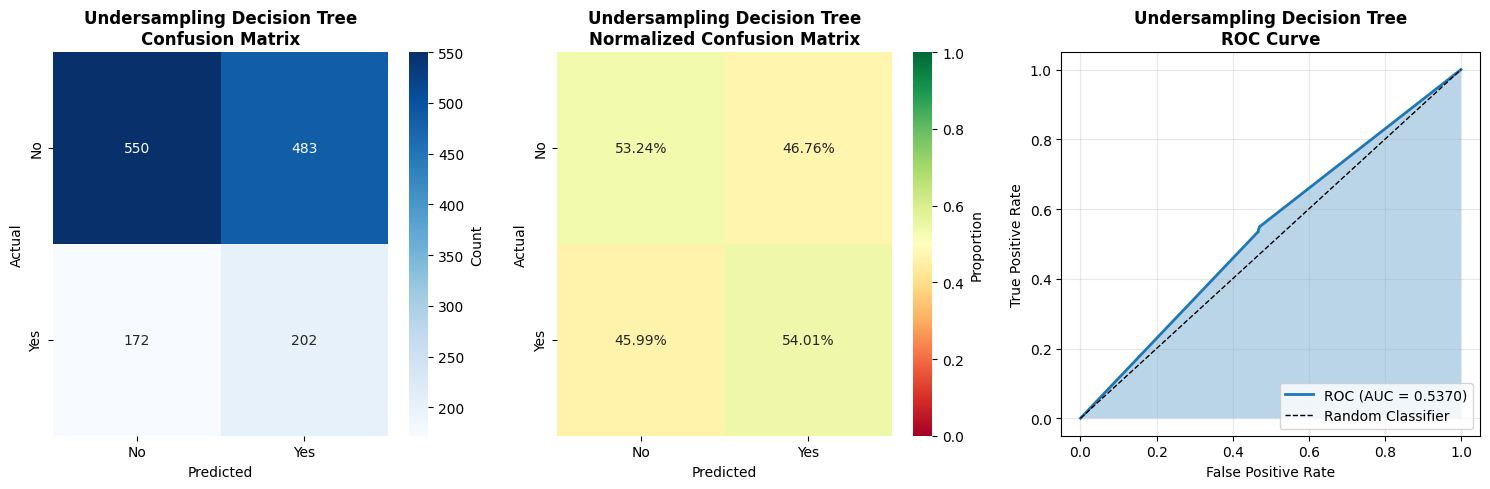


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.53      0.63      1033
         Yes       0.29      0.54      0.38       374

    accuracy                           0.53      1407
   macro avg       0.53      0.54      0.50      1407
weighted avg       0.64      0.53      0.56      1407


------------------------------------------------------------
Training Random Forest with Undersampling...
------------------------------------------------------------
Training Time: 0.65s

Undersampling Random Forest - Detailed Metrics
Accuracy:    0.5359
Precision:   0.2975
Recall:      0.5481
Specificity: 0.5315
F1-Score:    0.3857
MCC:         0.0703
Kappa:       0.0627

Confusion Matrix Components:
True Negatives:  549
False Positives: 484
False Negatives: 169
True Positives:  205


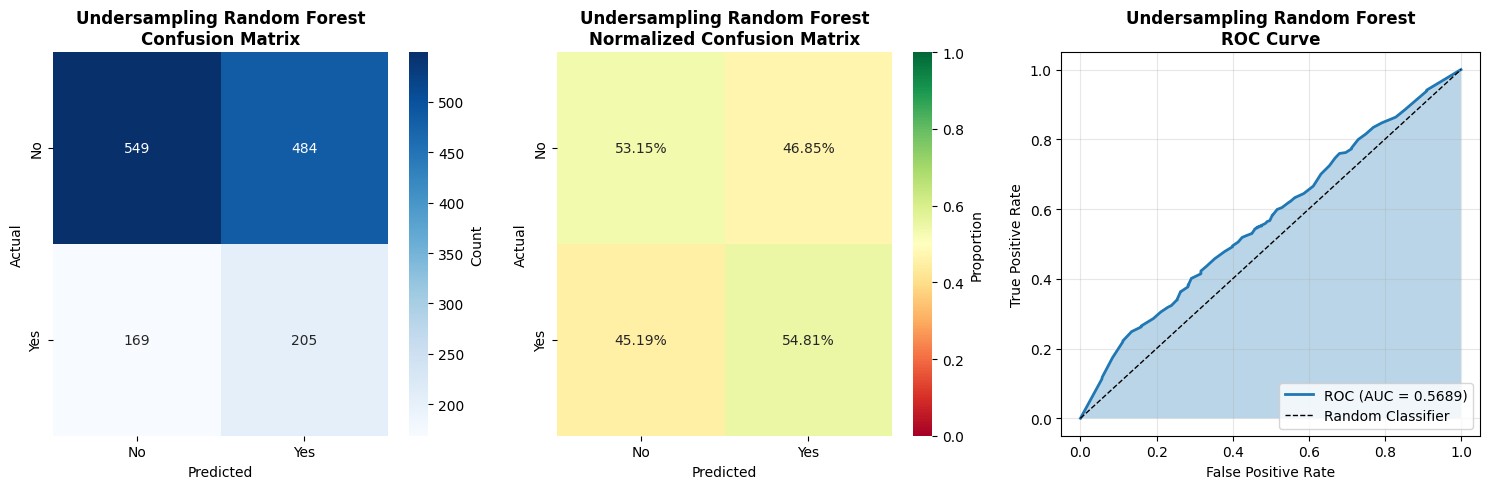


Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.53      0.63      1033
         Yes       0.30      0.55      0.39       374

    accuracy                           0.54      1407
   macro avg       0.53      0.54      0.51      1407
weighted avg       0.64      0.54      0.56      1407


REBALANCED MODELS - SUMMARY TABLE
       Rebalancer                Model  Accuracy  Precision  Recall  \
0           SMOTE  K-Nearest Neighbors    0.5707     0.3102  0.5027   
1           SMOTE          Naive Bayes    0.4840     0.3167  0.8128   
2           SMOTE        Decision Tree    0.5636     0.2993  0.4786   
3           SMOTE        Random Forest    0.5650     0.3010  0.4813   
4    Oversampling  K-Nearest Neighbors    0.5842     0.3178  0.4920   
5    Oversampling          Naive Bayes    0.4833     0.3163  0.8128   
6    Oversampling        Decision Tree    0.6311     0.3286  0.3717   
7    Oversampling        Random Forest    0.63

C:\Users\PC\AppData\Local\Temp\ipykernel_16244\2154234039.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


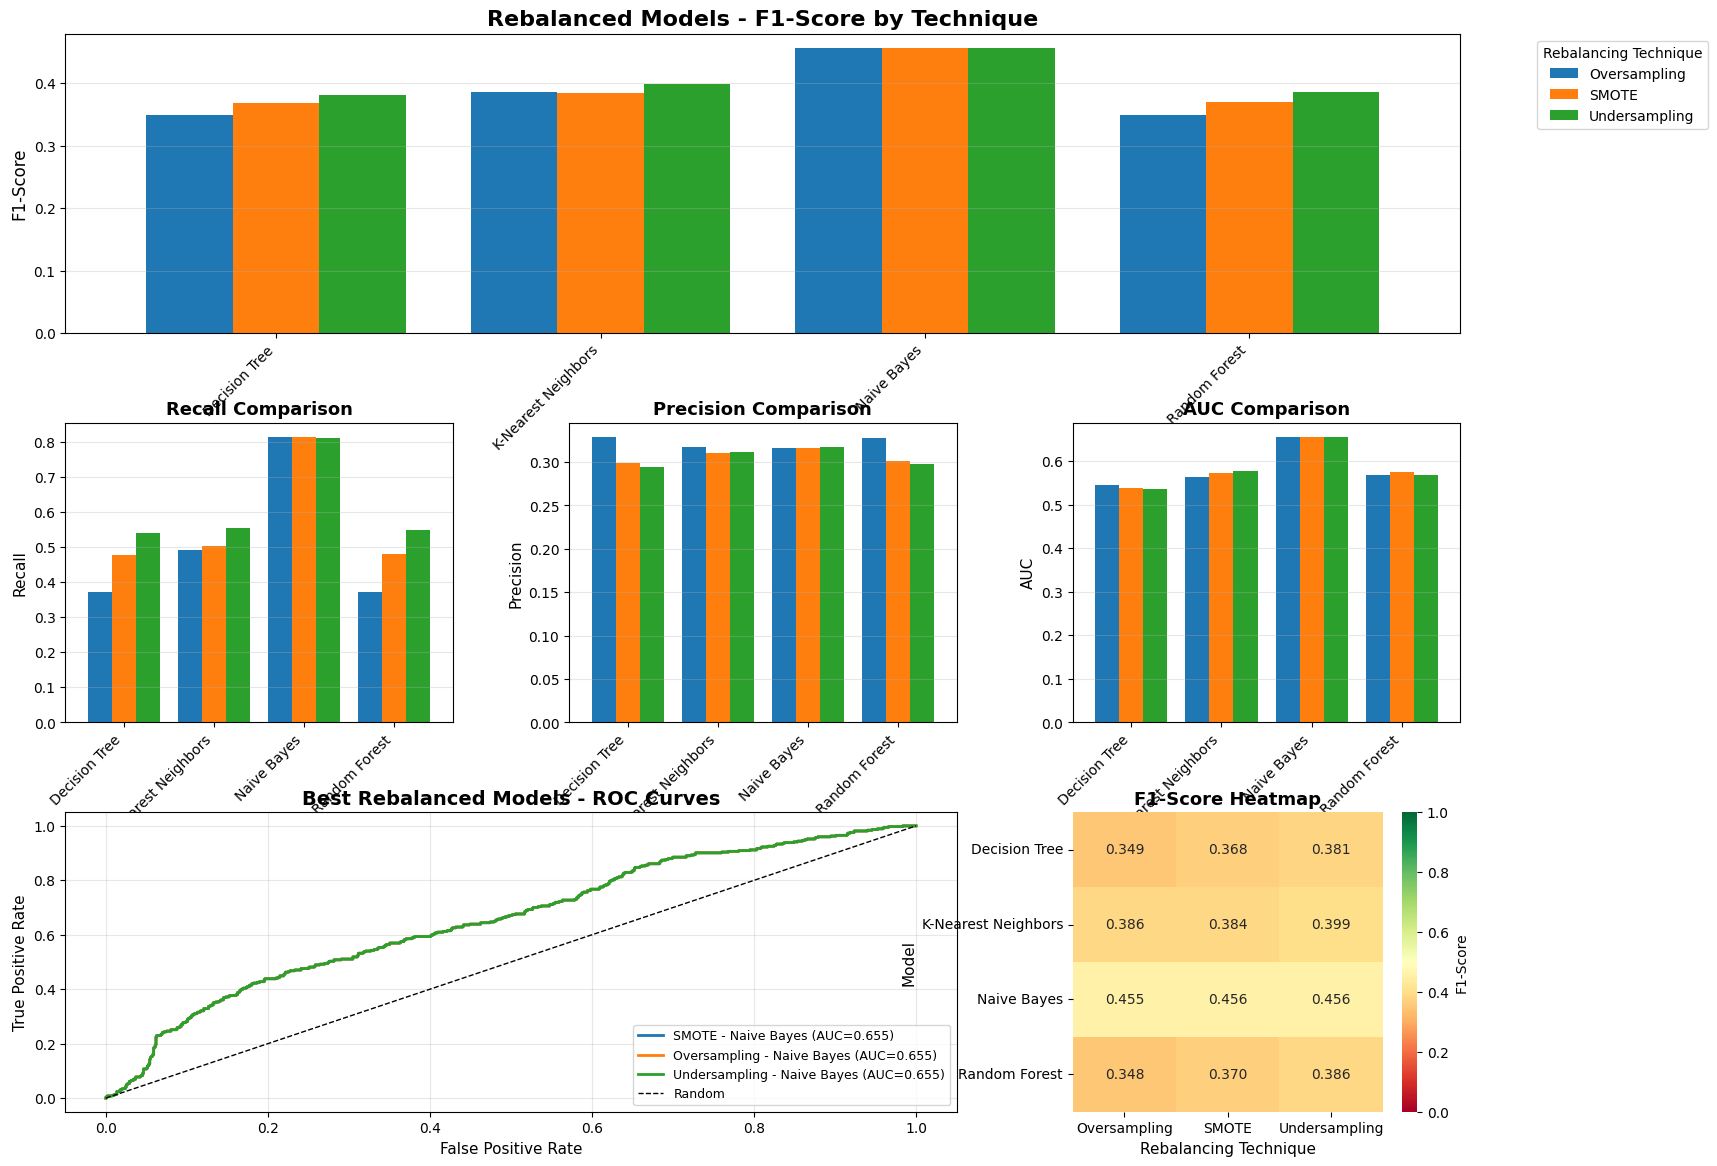


✓ Class rebalancing evaluation completed with comprehensive metrics and visualizations


In [ ]:
rebalanced_results = pd.DataFrame(columns=['Rebalancer', 'Model', 'Accuracy', 'Precision', 
                                           'Recall', 'Specificity', 'F1-Score', 'AUC', 'MCC', 
                                           'Kappa', 'TP', 'TN', 'FP', 'FN'])

print("\n" + "="*80)
print("CLASS REBALANCING EVALUATION - COMPREHENSIVE ANALYSIS")
print("="*80)

for rb_name, (X_res, y_res) in resampled_data.items():
    print(f"\n{'-'*80}")
    print(f"REBALANCING TECHNIQUE: {rb_name}")
    print(f"{'-'*80}")
    print(f"Training set size: {len(X_res)}")
    print(f"Class distribution: {pd.Series(y_res).value_counts().to_dict()}")
    
    for model_name, tuned_model in tuned_models.items():
        print(f"\n{'-'*60}")
        print(f"Training {model_name} with {rb_name}...")
        print(f"{'-'*60}")
        
        start_time = time.time()
        tuned_model.fit(X_res, y_res)
        train_time = time.time() - start_time
        print(f"Training Time: {train_time:.2f}s")
        
        # Comprehensive evaluation
        metrics = evaluate_model_comprehensive(tuned_model, X_test, y_test, 
                                               model_name, stage=f'{rb_name}')
        metrics['Rebalancer'] = rb_name
        rebalanced_results = pd.concat([rebalanced_results, pd.DataFrame([metrics])], 
                                       ignore_index=True)

print("\n" + "="*80)
print("REBALANCED MODELS - SUMMARY TABLE")
print("="*80)
print(rebalanced_results.round(4))

# Find best model for each rebalancing technique
print("\n" + "="*80)
print("BEST MODEL FOR EACH REBALANCING TECHNIQUE (by F1-Score)")
print("="*80)
best_per_rebalancer = rebalanced_results.loc[rebalanced_results.groupby('Rebalancer')['F1-Score'].idxmax()]
print(best_per_rebalancer[['Rebalancer', 'Model', 'F1-Score', 'Recall', 'Precision', 'AUC']].round(4))

# Overall best model across all stages
print("\n" + "="*80)
print("OVERALL BEST MODELS ACROSS ALL STAGES")
print("="*80)

# Combine all results
all_stages = []
for idx, row in results.iterrows():
    row_copy = row.copy()
    row_copy['Stage'] = 'Baseline'
    all_stages.append(row_copy)

for idx, row in tuned_results.iterrows():
    row_copy = row.copy()
    row_copy['Stage'] = 'Tuned'
    all_stages.append(row_copy)

for idx, row in rebalanced_results.iterrows():
    row_copy = row.copy()
    row_copy['Stage'] = row['Rebalancer']
    all_stages.append(row_copy)

all_stages_df = pd.DataFrame(all_stages)
best_overall = all_stages_df.nlargest(5, 'F1-Score')
print(best_overall[['Stage', 'Model', 'F1-Score', 'Recall', 'Precision', 'AUC']].round(4))

# Comprehensive Visualization: Rebalancing Comparison
fig = plt.figure(figsize=(18, 14))

# Create grid for subplots
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: F1-Score by Rebalancer and Model (Large)
ax1 = fig.add_subplot(gs[0, :])
pivot_f1 = rebalanced_results.pivot(index='Model', columns='Rebalancer', values='F1-Score')
pivot_f1.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Rebalanced Models - F1-Score by Technique', fontsize=16, fontweight='bold')
ax1.set_ylabel('F1-Score', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.legend(title='Rebalancing Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Recall by Rebalancer and Model
ax2 = fig.add_subplot(gs[1, 0])
pivot_recall = rebalanced_results.pivot(index='Model', columns='Rebalancer', values='Recall')
pivot_recall.plot(kind='bar', ax=ax2, width=0.8, legend=False)
ax2.set_title('Recall Comparison', fontsize=13, fontweight='bold')
ax2.set_ylabel('Recall', fontsize=11)
ax2.set_xlabel('Model', fontsize=11)
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 3: Precision by Rebalancer and Model
ax3 = fig.add_subplot(gs[1, 1])
pivot_precision = rebalanced_results.pivot(index='Model', columns='Rebalancer', values='Precision')
pivot_precision.plot(kind='bar', ax=ax3, width=0.8, legend=False)
ax3.set_title('Precision Comparison', fontsize=13, fontweight='bold')
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_xlabel('Model', fontsize=11)
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: AUC by Rebalancer and Model
ax4 = fig.add_subplot(gs[1, 2])
pivot_auc = rebalanced_results.pivot(index='Model', columns='Rebalancer', values='AUC')
pivot_auc.plot(kind='bar', ax=ax4, width=0.8, legend=False)
ax4.set_title('AUC Comparison', fontsize=13, fontweight='bold')
ax4.set_ylabel('AUC', fontsize=11)
ax4.set_xlabel('Model', fontsize=11)
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 5: ROC Curves for best rebalanced models
ax5 = fig.add_subplot(gs[2, :2])
for rb_name in rebalanced_results['Rebalancer'].unique():
    rb_data = rebalanced_results[rebalanced_results['Rebalancer'] == rb_name]
    best_model_name = rb_data.loc[rb_data['F1-Score'].idxmax(), 'Model']
    
    # Get the model and retrain (since it was trained multiple times)
    model = tuned_models[best_model_name]
    X_res, y_res = resampled_data[rb_name]
    model.fit(X_res, y_res)
    
    if hasattr(model, 'predict_proba'):
        if hasattr(model, 'classes_'):
            classes_list = list(model.classes_)
            yes_idx = classes_list.index('Yes') if 'Yes' in classes_list else 1
        else:
            yes_idx = 1
        
        y_prob = model.predict_proba(X_test)[:, yes_idx]
        y_test_bin = (y_test == 'Yes').astype(int)
        
        from sklearn.metrics import roc_curve, roc_auc_score
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
        auc = roc_auc_score(y_test_bin, y_prob)
        
        ax5.plot(fpr, tpr, linewidth=2, label=f'{rb_name} - {best_model_name} (AUC={auc:.3f})')

ax5.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax5.set_xlabel('False Positive Rate', fontsize=11)
ax5.set_ylabel('True Positive Rate', fontsize=11)
ax5.set_title('Best Rebalanced Models - ROC Curves', fontsize=14, fontweight='bold')
ax5.legend(loc='lower right', fontsize=9)
ax5.grid(True, alpha=0.3)

# Plot 6: Heatmap of F1-Scores
ax6 = fig.add_subplot(gs[2, 2])
pivot_f1_heat = rebalanced_results.pivot(index='Model', columns='Rebalancer', values='F1-Score')
sns.heatmap(pivot_f1_heat, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax6, 
            cbar_kws={'label': 'F1-Score'}, vmin=0, vmax=1)
ax6.set_title('F1-Score Heatmap', fontsize=13, fontweight='bold')
ax6.set_xlabel('Rebalancing Technique', fontsize=11)
ax6.set_ylabel('Model', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Class rebalancing evaluation completed with comprehensive metrics and visualizations")


***10. Comparaison Finale***


Overall Comparison Table:
             Stage                Model  Accuracy  Precision    Recall  \
0        Baseline  K-Nearest Neighbors  0.714286   0.442623  0.288770   
1        Baseline          Naive Bayes  0.734186   0.000000  0.000000   
2        Baseline        Decision Tree  0.630419   0.321951  0.352941   
3        Baseline        Random Forest  0.631130   0.324455  0.358289   
4           Tuned  K-Nearest Neighbors  0.690121   0.393103  0.304813   
5           Tuned          Naive Bayes  0.734186   0.000000  0.000000   
6           Tuned        Decision Tree  0.630419   0.321951  0.352941   
7           Tuned        Random Forest  0.632552   0.326034  0.358289   
8           SMOTE  K-Nearest Neighbors  0.570718   0.310231  0.502674   
9           SMOTE          Naive Bayes  0.484009   0.316667  0.812834   
10          SMOTE        Decision Tree  0.563611   0.299331  0.478610   
11          SMOTE        Random Forest  0.565032   0.301003  0.481283   
12   Oversampling  K-Ne

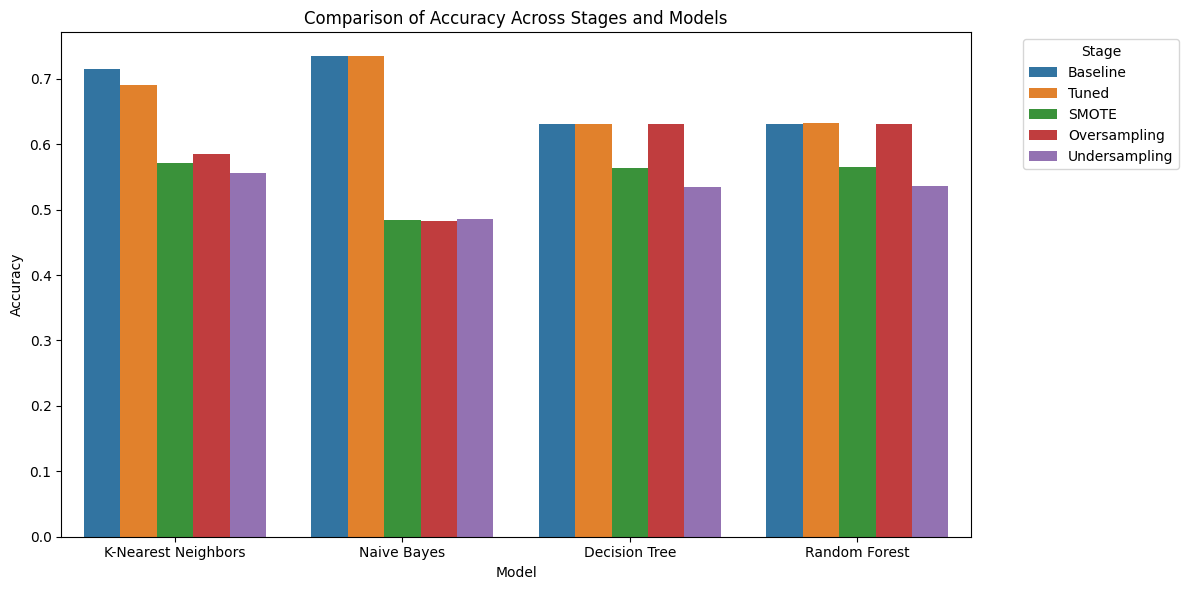

<Figure size 640x480 with 0 Axes>

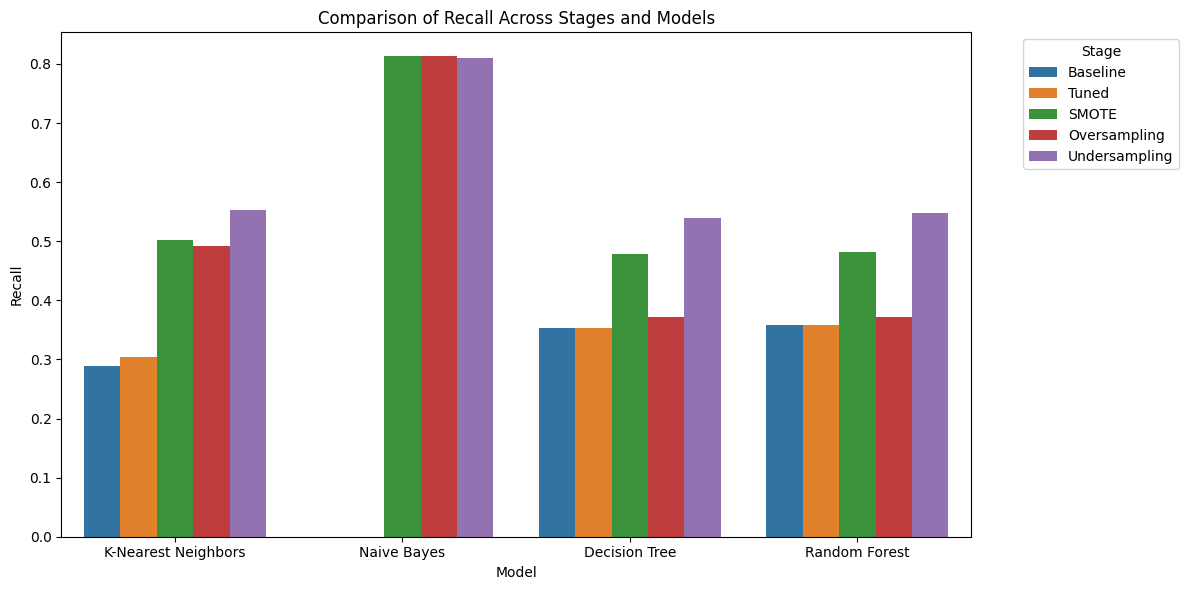

<Figure size 640x480 with 0 Axes>

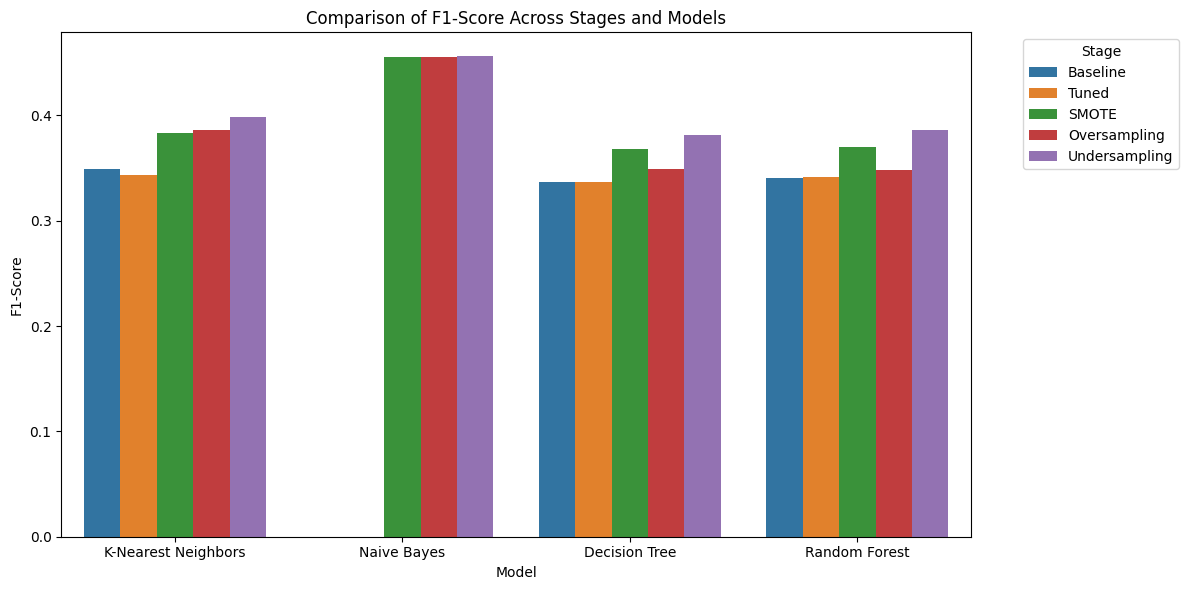

<Figure size 640x480 with 0 Axes>

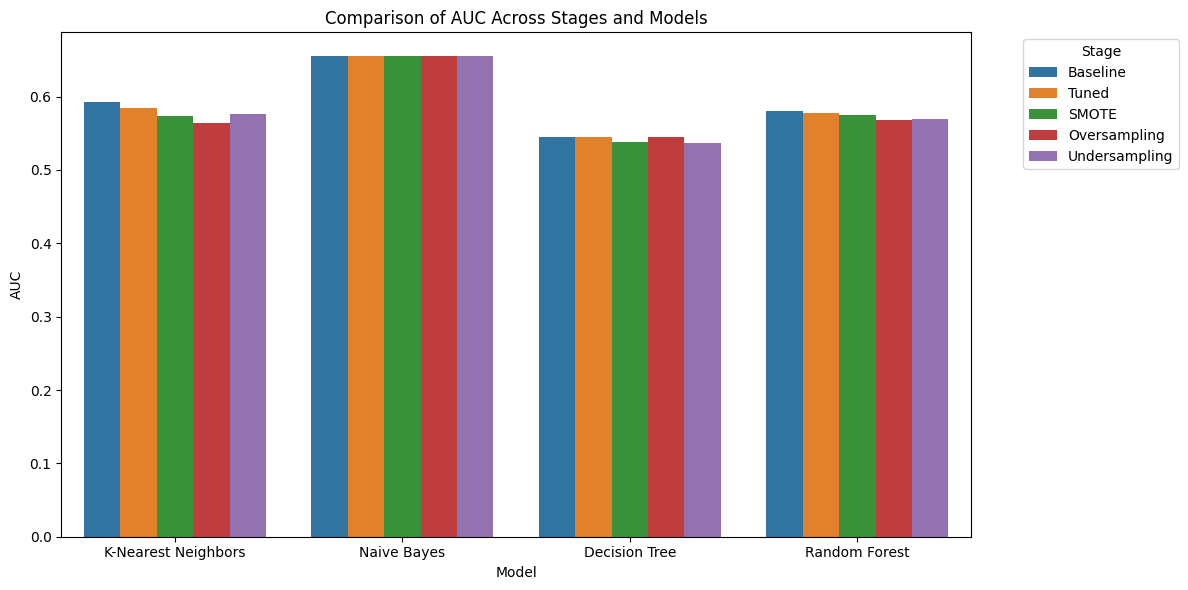

<Figure size 640x480 with 0 Axes>

In [90]:
baseline = results.copy()
baseline['Stage'] = 'Baseline'
tuned = tuned_results.copy()
tuned['Stage'] = 'Tuned'
rebalanced = rebalanced_results.copy()
rebalanced['Stage'] = rebalanced['Rebalancer']  # Use rebalancer as sub-stage
rebalanced.drop('Rebalancer', axis=1, inplace=True)  # Avoid duplication

# Combine all
all_results = pd.concat([baseline, tuned, rebalanced], ignore_index=True)

# Reorder columns for clarity
all_results = all_results[['Stage', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']]

# Display and save master table
print("\nOverall Comparison Table:\n", all_results)
all_results.to_csv('overall_results.csv', index=False)

# Graphical Visualizations: Bar plots for key metrics by stage and model
metrics_to_plot = ['Accuracy', 'Recall', 'F1-Score', 'AUC']  # Focus on these for churn (recall/F1 important)

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric, hue='Stage', data=all_results)
    plt.title(f'Comparison of {metric} Across Stages and Models')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{metric}_comparison.png')


FINAL COMPREHENSIVE COMPARISON - ALL STAGES

📊 TOP 10 MODELS OVERALL (by F1-Score):
            Stage                Model  F1-Score  Recall  Precision     AUC  \
1   Undersampling          Naive Bayes    0.4560  0.8102     0.3173  0.6549   
2           SMOTE          Naive Bayes    0.4558  0.8128     0.3167  0.6549   
3    Oversampling          Naive Bayes    0.4554  0.8128     0.3163  0.6549   
4   Undersampling  K-Nearest Neighbors    0.3988  0.5535     0.3117  0.5766   
5    Oversampling  K-Nearest Neighbors    0.3861  0.4920     0.3178  0.5636   
6   Undersampling        Random Forest    0.3857  0.5481     0.2975  0.5689   
7           SMOTE  K-Nearest Neighbors    0.3837  0.5027     0.3102  0.5736   
8   Undersampling        Decision Tree    0.3815  0.5401     0.2949  0.5370   
9           SMOTE        Random Forest    0.3704  0.4813     0.3010  0.5756   
10          SMOTE        Decision Tree    0.3683  0.4786     0.2993  0.5387   

       MCC  
1   0.1693  
2   0.1687  
3   0.

C:\Users\PC\AppData\Local\Temp\ipykernel_16244\2218099295.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


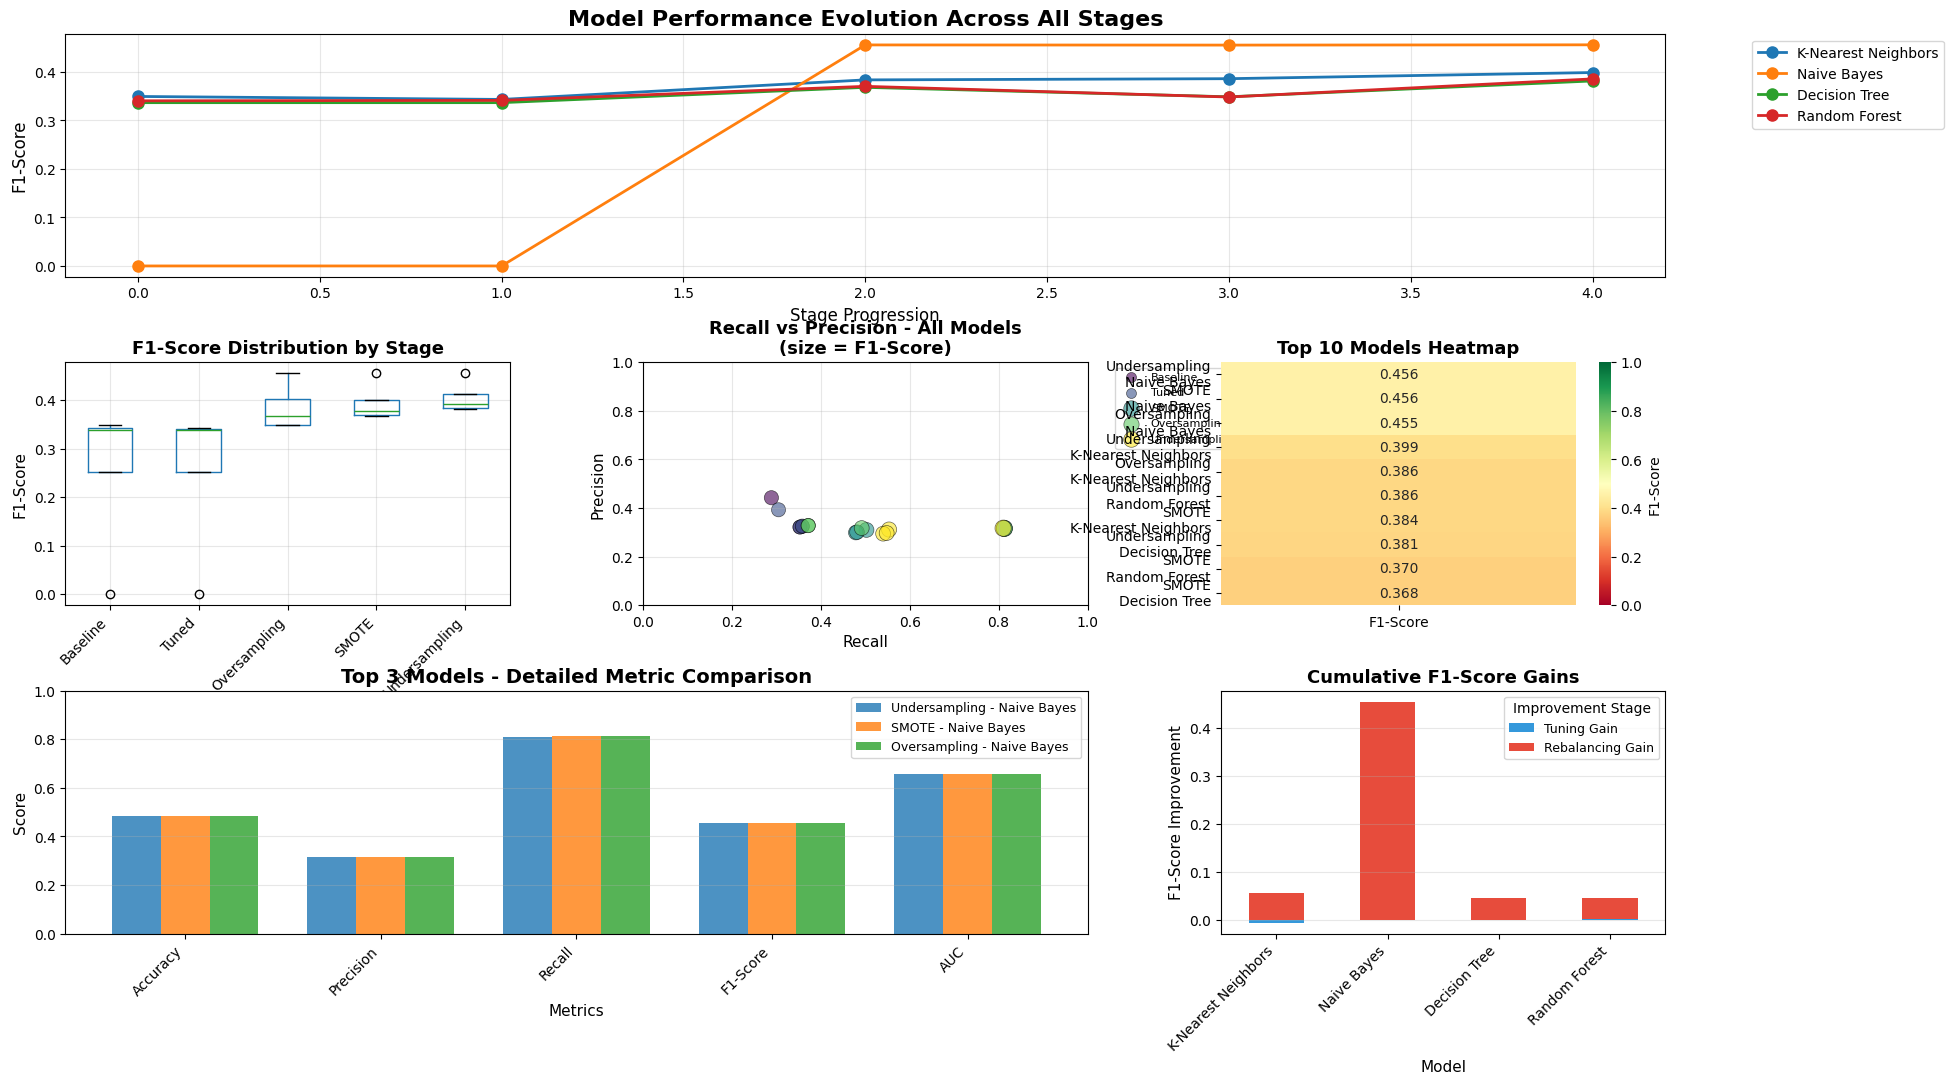


✅ All results saved to 'all_stages_results.csv'

🏆 RECOMMENDED MODEL FOR DEPLOYMENT:
Stage: Undersampling
Model: Naive Bayes
F1-Score: 0.4560
Recall: 0.8102
Precision: 0.3173
AUC: 0.6549
MCC: 0.1693


In [ ]:
print("\n" + "="*80)
print("FINAL COMPREHENSIVE COMPARISON - ALL STAGES")
print("="*80)

# Prepare consolidated dataframe
baseline_df = results.copy()
baseline_df['Stage'] = 'Baseline'

tuned_df = tuned_results.copy()
tuned_df['Stage'] = 'Tuned'

rebalanced_df = rebalanced_results.copy()
rebalanced_df['Stage'] = rebalanced_df['Rebalancer']
rebalanced_df = rebalanced_df.drop('Rebalancer', axis=1)

# Combine all
all_results = pd.concat([baseline_df, tuned_df, rebalanced_df], ignore_index=True)

# Display top 10 models overall
print("\n📊 TOP 10 MODELS OVERALL (by F1-Score):")
print("="*80)
top_10 = all_results.nlargest(10, 'F1-Score')[['Stage', 'Model', 'F1-Score', 'Recall', 
                                                 'Precision', 'AUC', 'MCC']].reset_index(drop=True)
top_10.index = range(1, 11)
print(top_10.round(4))

# Create ultimate comparison visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: F1-Score evolution across stages
ax1 = fig.add_subplot(gs[0, :])
for model in results['Model'].unique():
    model_data = all_results[all_results['Model'] == model]
    stages_order = ['Baseline', 'Tuned'] + [s for s in model_data['Stage'].unique() 
                                             if s not in ['Baseline', 'Tuned']]
    model_data_sorted = model_data.set_index('Stage').loc[
        [s for s in stages_order if s in model_data['Stage'].values]
    ].reset_index()
    ax1.plot(range(len(model_data_sorted)), model_data_sorted['F1-Score'], 
            marker='o', linewidth=2, markersize=8, label=model)

ax1.set_xlabel('Stage Progression', fontsize=12)
ax1.set_ylabel('F1-Score', fontsize=12)
ax1.set_title('Model Performance Evolution Across All Stages', fontsize=16, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Box plot of F1-Scores by Stage
ax2 = fig.add_subplot(gs[1, 0])
stage_order = ['Baseline', 'Tuned'] + sorted([s for s in all_results['Stage'].unique() 
                                               if s not in ['Baseline', 'Tuned']])
all_results['Stage_cat'] = pd.Categorical(all_results['Stage'], categories=stage_order, ordered=True)
all_results.boxplot(column='F1-Score', by='Stage_cat', ax=ax2)
ax2.set_xlabel('Stage', fontsize=11)
ax2.set_ylabel('F1-Score', fontsize=11)
ax2.set_title('F1-Score Distribution by Stage', fontsize=13, fontweight='bold')
plt.suptitle('')  # Remove default title
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 3: Recall vs Precision scatter (all models, all stages)
ax3 = fig.add_subplot(gs[1, 1])
colors = plt.cm.viridis(np.linspace(0, 1, len(all_results['Stage'].unique())))
stage_colors = dict(zip(all_results['Stage'].unique(), colors))

for stage in all_results['Stage'].unique():
    stage_data = all_results[all_results['Stage'] == stage]
    ax3.scatter(stage_data['Recall'], stage_data['Precision'], 
               s=stage_data['F1-Score']*300, alpha=0.6, 
               c=[stage_colors[stage]], label=stage, edgecolors='black', linewidth=0.5)

ax3.set_xlabel('Recall', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_title('Recall vs Precision - All Models\n(size = F1-Score)', fontsize=13, fontweight='bold')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

# Plot 4: Heatmap of top models
ax4 = fig.add_subplot(gs[1, 2])
top_10_pivot = top_10[['Model', 'Stage', 'F1-Score']].copy()
top_10_pivot['Label'] = top_10_pivot['Stage'] + '\n' + top_10_pivot['Model']
heatmap_data = top_10_pivot.set_index('Label')['F1-Score'].values.reshape(-1, 1)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
           yticklabels=top_10_pivot['Label'], xticklabels=['F1-Score'],
           ax=ax4, cbar_kws={'label': 'F1-Score'}, vmin=0, vmax=1)
ax4.set_title('Top 10 Models Heatmap', fontsize=13, fontweight='bold')

# Plot 5: Metric comparison for top 3 models
ax5 = fig.add_subplot(gs[2, :2])
top_3 = all_results.nlargest(3, 'F1-Score')
metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics_cols))
width = 0.25

for i, (idx, row) in enumerate(top_3.iterrows()):
    label = f"{row['Stage']} - {row['Model']}"
    ax5.bar(x + i*width, [row[m] for m in metrics_cols], width, label=label, alpha=0.8)

ax5.set_xlabel('Metrics', fontsize=11)
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Top 3 Models - Detailed Metric Comparison', fontsize=14, fontweight='bold')
ax5.set_xticks(x + width)
ax5.set_xticklabels(metrics_cols, rotation=45, ha='right')
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0, 1])

# Plot 6: Performance improvement summary
ax6 = fig.add_subplot(gs[2, 2])
improvement_data = []
for model in results['Model'].unique():
    baseline_f1 = results[results['Model'] == model]['F1-Score'].values[0]
    tuned_f1 = tuned_results[tuned_results['Model'] == model]['F1-Score'].values[0]
    best_rebal_f1 = rebalanced_results[rebalanced_results['Model'] == model]['F1-Score'].max()
    
    improvement_data.append({
        'Model': model,
        'Tuning Gain': tuned_f1 - baseline_f1,
        'Rebalancing Gain': best_rebal_f1 - tuned_f1
    })

improvement_df = pd.DataFrame(improvement_data)
improvement_df.plot(x='Model', kind='bar', ax=ax6, stacked=True, color=['#3498db', '#e74c3c'])
ax6.set_xlabel('Model', fontsize=11)
ax6.set_ylabel('F1-Score Improvement', fontsize=11)
ax6.set_title('Cumulative F1-Score Gains', fontsize=13, fontweight='bold')
ax6.legend(title='Improvement Stage', fontsize=9)
ax6.grid(axis='y', alpha=0.3)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Save results
all_results.to_csv('all_stages_results.csv', index=False)

print("\n" + "="*80)
print("RECOMMENDED MODEL FOR DEPLOYMENT:")
print("="*80)
best_model_row = all_results.loc[all_results['F1-Score'].idxmax()]
print(f"Stage: {best_model_row['Stage']}")
print(f"Model: {best_model_row['Model']}")
print(f"F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"Recall: {best_model_row['Recall']:.4f}")
print(f"Precision: {best_model_row['Precision']:.4f}")
print(f"AUC: {best_model_row['AUC']:.4f}")
print(f"MCC: {best_model_row['MCC']:.4f}")
print("="*80)
